In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import resample
from scipy.stats import sem, t
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import resample
from scipy.stats import sem, t
import seaborn as sns
import numpy as np
#from Bio.SeqUtils.ProtParam import ProtParam
from sklearn.utils import resample
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mannwhitneyu
import re
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import ProtParam

In [23]:
def compute_ci(df, num_bootstraps, ci_level):
    corr_bootstraps = []
    num_cols = df.shape[1]
    
    for _ in range(num_bootstraps):
        df_boot = df.apply(lambda x: resample(x, replace=True, random_state=_))
        if num_cols > 1:
            corr_boot = df_boot.corr().values.flatten()
        else:
            # If only one column, compute correlation with itself (which is always 1)
            corr_boot = np.array([1.0])
        corr_bootstraps.append(corr_boot)

    corr_bootstraps = np.array(corr_bootstraps)
    ci_lower = np.percentile(corr_bootstraps, (1 - ci_level) / 2 * 100, axis=0)
    ci_upper = np.percentile(corr_bootstraps, (1 + ci_level) / 2 * 100, axis=0)

    return ci_lower, ci_upper

aro_aa = ['F', "Y", "W", "H"]
def extract_integers(s):
    return [int(match.group()) for match in re.finditer(r'\d+', s)]

def pearsonr_ci(x, y, alpha=0.05):
    r, p = stats.pearsonr(x, y)
    n = len(x)
    r_z = np.arctanh(r)
    se = 1 / np.sqrt(x.size - 3)
    z = stats.norm.ppf(1 - alpha / 2)
    lo_z, hi_z = r_z - z * se, r_z + z * se
    lo, hi = np.tanh((lo_z, hi_z))
    err = (hi - p) + (p - lo)
    return r, p, lo, hi,n, err

def plot_sig_boxplot(df, data_call, functional_column, predictor, title):
    df = df[df['predictor'] == predictor]
    group_0 = df[df[functional_column] == 'Neutral'][data_call]
    group_1 = df[df[functional_column] == 'Deleterious'][data_call]
    statistic, p_value = mannwhitneyu(group_0, group_1)
 
    # Plot box plot
    ax = plt.gca()
    sns.boxplot(x=functional_column, y=data_call, data=df, ax=ax)
    ax.set_xlabel('Functional Classification', fontsize=14, fontweight='bold')  # Increase font size
    ax.set_ylabel('|ΔΔG|', fontsize=14, fontweight='bold')  # Increase font size
    plt.xticks(size=14)
    plt.tick_params(axis='x', width=2)  # Increase thickness of x ticks
    plt.tick_params(axis='y', width=2)
    ax.set_title(f'{predictor} |ΔΔG| in {title}', fontsize=14)  # Increase font size

    # Add significance bars
    if p_value < 0.05:
        significant_combinations = [((0.25, 0.75), p_value)]  # Example combination, change as needed
        y_range = max(max(group_0), max(group_1)) - min(min(group_0), min(group_1))
        top = max(max(group_0), max(group_1))
    
        # Plot significance bars
        for i, significant_combination in enumerate(significant_combinations):
            x1 = significant_combination[0][0] - 0.1  # Adjusting the start of the bar
            x2 = significant_combination[0][1] + 0.1  # Adjusting the end of the bar
            level = len(significant_combinations) - i
            bar_height = (y_range * 0.07 * level) + top
            bar_tips = bar_height - (y_range * 0.02)
            ax.plot([x1, x1, x2, x2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
        
            # Significance level
            p = significant_combination[1]
            if p < 0.001:
                sig_symbol = '***'
            elif p < 0.01:
                sig_symbol = '**'
            elif p < 0.05:
                sig_symbol = '*'
            text_height = bar_height + (y_range * 0.01)
            ax.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
            
def plot_sig_boxplot_ax(df, data_call, functional_column, predictor, ax):
    df = df[df['predictor'] == predictor]
    group_0 = df[df[functional_column] == 'Neutral'][data_call]
    group_1 = df[df[functional_column] == 'Deleterious'][data_call]
    statistic, p_value = mannwhitneyu(group_0, group_1)
 
    # Plot box plot
    #ax = plt.gca()
    sns.boxplot(x=functional_column, y=data_call, data=df, ax=ax)
    ax.set_xlabel('Functional Classification', fontsize=14)  # Increase font size
    ax.set_ylabel(title, fontsize=14)  # Increase font size
    #ax.set_title(f'{predictor} ΔΔG in {title}', fontsize=14)  # Increase font size

    # Add significance bars
    if p_value < 0.05:
        significant_combinations = [((0.25, 0.75), p_value)]  # Example combination, change as needed
        y_range = max(max(group_0), max(group_1)) - min(min(group_0), min(group_1))
        top = max(max(group_0), max(group_1))
    
        # Plot significance bars
        for i, significant_combination in enumerate(significant_combinations):
            x1 = significant_combination[0][0] - 0.1  # Adjusting the start of the bar
            x2 = significant_combination[0][1] + 0.1  # Adjusting the end of the bar
            level = len(significant_combinations) - i
            bar_height = (y_range * 0.07 * level) + top
            bar_tips = bar_height - (y_range * 0.02)
            ax.plot([x1, x1, x2, x2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
        
            # Significance level
            p = significant_combination[1]
            if p < 0.001:
                sig_symbol = '***'
            elif p < 0.01:
                sig_symbol = '**'
            elif p < 0.05:
                sig_symbol = '*'
            text_height = bar_height + (y_range * 0.01)
            ax.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

In [24]:
BRCA1_ddg_results_df = pd.read_csv("BRCA1_data_function_ddg.csv")
BRCA2_ddg_results_df = pd.read_csv("BRCA2_data_function_ddg.csv")
PALB2_ddg_results_df = pd.read_csv("PALB2_data_function_ddg.csv")
RAD51C_ddg_results_df = pd.read_csv("RAD51C_data_function_ddg.csv")
ddg_results_df = pd.concat([BRCA1_ddg_results_df,BRCA2_ddg_results_df,
                           PALB2_ddg_results_df, RAD51C_ddg_results_df], axis=0)
ddg_results_df = ddg_results_df.reset_index(drop=True)
ddg_results_df[['struct_predictor', 'struct_type']] = ddg_results_df['dtype'].str.split('_', expand=True)
ddg_results_df['GENE_MODEL'] = ddg_results_df['GENE'] + "_" + ddg_results_df['model']
ddg_results_df['ΔΔG'] = ddg_results_df.ddg.abs()
#ddg_results_function_df = ddg_results_df[~ddg_results_df['HDR'].isna()]
ddg_results_function_df = ddg_results_df[~ddg_results_df['Class'].isna()]

ddg_results_function_df = ddg_results_function_df.reset_index(drop=True)
BRCA1_1JNX_crystal_df = ddg_results_function_df[(ddg_results_function_df['model'] == "1JNX") &
                                                                 (ddg_results_function_df['struct_predictor'] == "crystal")]
BRCA1_1JNX_AF2_df = ddg_results_function_df[(ddg_results_function_df['model'] == "1JNX") &
                                                                 (ddg_results_function_df['struct_predictor'] == "AF2")]
PALB2_2W18_crystal_df = ddg_results_function_df[(ddg_results_function_df['model'] == "2W18") &
                                                                 (ddg_results_function_df['struct_predictor'] == "crystal")]
PALB2_2W18_AF2_df = ddg_results_function_df[(ddg_results_function_df['model'] == "2W18") &
                                                                 (ddg_results_function_df['struct_predictor'] == "AF2")]
ddg_results_function_complex_crystal_df = ddg_results_function_df[(ddg_results_function_df['struct_type'] == "complex") &
                                                                 (ddg_results_function_df['struct_predictor'] == "crystal")]
ddg_results_function_complex_crystal_df = pd.concat([ddg_results_function_complex_crystal_df,
                                                    BRCA1_1JNX_crystal_df, PALB2_2W18_crystal_df], axis=0)
ddg_results_function_complex_AF2_df = ddg_results_function_df[(ddg_results_function_df['struct_type'] == "complex") &
                                                         (ddg_results_function_df['struct_predictor'] == "AF2")]
ddg_results_function_complex_AF2_df = pd.concat([ddg_results_function_complex_AF2_df,
                                                BRCA1_1JNX_AF2_df, PALB2_2W18_AF2_df], axis=0)
ddg_results_function_complex_AF2_df = ddg_results_function_complex_AF2_df[(ddg_results_function_complex_AF2_df['Class'] == 'Normal') |
                                                                         (ddg_results_function_complex_AF2_df['Class'] == 'Abnormal')]

ddg_results_function_complex_crystal_df = ddg_results_function_complex_crystal_df[(ddg_results_function_complex_crystal_df['Class'] == 'Normal') |
                                                                         (ddg_results_function_complex_crystal_df['Class'] == 'Abnormal')]

#PALB2_ddg_results_df[PALB2_ddg_results_df['model'] == "2W18"]
#PALB2_2W18_crystal_df
#ddg_results_function_complex_crystal_df[ddg_results_function_complex_crystal_df['model'] =='2W18']['Class'].value_counts()
ddg_results_function_complex_crystal_df

,mutations,ddg,REF_POS,model,dtype,predictor,GENE,HDR,Class,ClinVar_Class,struct_predictor,struct_type,GENE_MODEL,ΔΔG
7769,A5D,-0.616949,A5,7LYB,crystal_complex,FoldX,BRCA1,0.132687,Normal,NaN,crystal,complex,BRCA1_7LYB,0.616949
7770,A5G,-1.646190,A5,7LYB,crystal_complex,FoldX,BRCA1,-0.591609,Normal,NaN,crystal,complex,BRCA1_7LYB,1.646190
7772,A5S,-0.130693,A5,7LYB,crystal_complex,FoldX,BRCA1,-0.261441,Normal,NaN,crystal,complex,BRCA1_7LYB,0.130693
7773,A5T,0.232791,A5,7LYB,crystal_complex,FoldX,BRCA1,-0.087838,Normal,NaN,crystal,complex,BRCA1_7LYB,0.232791
7774,A5V,2.150966,A5,7LYB,crystal_complex,FoldX,BRCA1,0.314080,Normal,NaN,crystal,complex,BRCA1_7LYB,2.150966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23877,F948L,1.355838,F948,2W18,crystal_subunit,Rosetta,PALB2,NaN,Normal,Normal,crystal,subunit,PALB2_2W18,1.355838
23878,Q958P,111.610129,Q958,2W18,crystal_subunit,Rosetta,PALB2,6.178161,Normal,NaN,crystal,subunit,PALB2_2W18,111.610129
23879,L961P,95.676487,L961,2W18,crystal_subunit,Rosetta,PALB2,1.290000,Abnormal,NaN,crystal,subunit,PALB2_2W18,95.676487
23880,S981N,0.635568,S981,2W18,crystal_subunit,Rosetta,PALB2,NaN,Normal,Normal,crystal,subunit,PALB2_2W18,0.635568


In [25]:
#ddg_results_function_complex_crystal_df
#grouped = ddg_results_function_complex_crystal_df.groupby(['GENE','model', 'predictor'])

# Initialize a dictionary to store PR-AUC scores for each group
#pr_auc_scores = {}

# Iterate over each group
#for (model, predictor), group_df in grouped:
#    labels = group_df['Class'].map({'Normal': 0, 'Abnormal': 1})
#    pr_auc = average_precision_score(labels, group_df['ΔΔG'])
#    pr_auc_scores[(model, predictor)] = pr_auc

# Convert the dictionary to a DataFrame
#pr_auc_df = pd.DataFrame(pr_auc_scores.items(), columns=['Model_Predictor', 'PR_AUC'])

# Display the DataFrame
#print(pr_auc_df)
#n_bootstrap = 1000

# Initialize a list to store bootstrapped PR-AUC scores
#bootstrapped_pr_auc_scores = []

# Iterate over each group
#for (GENE, model, predictor), group_df in grouped:
#    labels = group_df['Class'].map({'Neutral': 0, 'Deleterious': 1})
    
    # Perform bootstrapping to calculate PR-AUC scores
#    pr_auc_samples = []
#    for _ in range(n_bootstrap):
        # Sample with replacement from the data
#        bootstrap_data = resample(group_df, replace=True)
#        bootstrap_labels = bootstrap_data['Class'].map({'Neutral': 0, 'Deleterious': 1})
        # Calculate PR-AUC score for the bootstrapped sample
#        pr_auc = average_precision_score(bootstrap_labels, bootstrap_data['ΔΔG'])
#        pr_auc_samples.append(pr_auc)
    
    # Calculate mean and confidence interval for PR-AUC scores
#    pr_auc_mean = np.mean(pr_auc_samples)
#    pr_auc_ci_lower = np.percentile(pr_auc_samples, 2.5)
#    pr_auc_ci_upper = np.percentile(pr_auc_samples, 97.5)
    
    # Store mean and confidence interval in the dictionary
#    bootstrapped_pr_auc_scores.append({
#        'Predictor': predictor,
#        'Model':model,
#        'Gene': GENE,  
#        'PR_AUC_Mean': pr_auc_mean,
#        'PR_AUC_CI_Lower': pr_auc_ci_lower,
#        'PR_AUC_CI_Upper': pr_auc_ci_upper
#    })

# Convert the list of dictionaries to a DataFrame
#bootstrapped_pr_auc_df = pd.DataFrame(bootstrapped_pr_auc_scores)

# Display the DataFrame
#print(bootstrapped_pr_auc_df)


In [26]:
grouped = ddg_results_function_complex_crystal_df.groupby(['GENE','model', 'predictor'])
# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

def delong_pr_auc_variance(y_true, y_pred):
    order, label_1_count = compute_ground_truth_statistics(y_true)
    predictions_sorted_transposed = np.vstack((y_pred, y_pred))[:, order]
    pr_aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    #pr_aucs = average_precision_score
    return pr_aucs[0], delongcov

def compute_pr_auc_ci(y_true, y_pred, n_bootstrap=1000, alpha=0.95):
    pr_auc, pr_auc_cov = delong_pr_auc_variance(y_true, y_pred)
    pr_auc_std = np.sqrt(pr_auc_cov)
    
    # Perform bootstrapping to calculate PR-AUC scores
    pr_auc_samples = []
    for _ in range(n_bootstrap):
        # Sample with replacement from the data
        y_true_boot, y_pred_boot = resample(y_true, y_pred)
        # Calculate PR-AUC score for the bootstrapped sample
        pr_auc_boot = average_precision_score(y_true_boot, y_pred_boot)
        pr_auc_samples.append(pr_auc_boot)
    
    # Calculate the confidence interval
    lower_quantile = (1 - alpha) / 2.0 * 100
    upper_quantile = (alpha + (1 - alpha) / 2.0) * 100
    ci = np.percentile(pr_auc_samples, [lower_quantile, upper_quantile])
    
    return pr_auc, pr_auc_std, ci


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)


#pr_auc_results = []

# Iterate over each group
#for (GENE, model, predictor), group_df in grouped:
#    y_true = group_df['Class'].map({'Normal': 0, 'Abnormal': 1})
#    y_pred = group_df['ΔΔG']
    
    # Compute PR-AUC and confidence interval
#    pr_auc, pr_auc_std, ci = compute_pr_auc_ci(y_true, y_pred)
    
    # Append the results to the list
#    pr_auc_results.append({
#        'Gene': GENE,
#        'Model': model,
#        'Predictor': predictor,
#        'PR_AUC': pr_auc,
#        'PR_AUC_CI_Lower': ci[0],
#        'PR_AUC_CI_Upper': ci[1]
#    })

# Convert the list of dictionaries to a DataFrame
#pr_auc_df = pd.DataFrame(pr_auc_results)

# Display the DataFrame
#print(pr_auc_df)
auc_results = []

for (GENE, model, predictor), group_df in grouped:
    y_true = group_df['Class'].map({'Normal': 0, 'Abnormal': 1})
    alpha = .95
    y_pred = group_df['ΔΔG']
    auc, auc_cov = delong_roc_variance(y_true,y_pred)
    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
    ci = stats.norm.ppf(lower_upper_q,loc=auc,scale=auc_std)
    ci[ci > 1] = 1
    auc_results.append({'Gene': GENE,
                        'Model': model,
                        'Predictor': predictor,
                        'AUC': auc,
                        'AUC_CI_Lower': ci[0],
                        'AUC_CI_Upper': ci[1]})
    #print(GENE, model, predictor)
    #print('AUC:', auc)
    #print('AUC COV:', auc_cov)
    #print('95% AUC CI:', ci)
auc_df = pd.DataFrame(auc_results)
print(auc_df)

      Gene Model Predictor       AUC  AUC_CI_Lower  AUC_CI_Upper
0    BRCA1  1JNX   DDgun3D  0.739541      0.704506      0.774577
1    BRCA1  1JNX     FoldX  0.808375      0.775725      0.841025
2    BRCA1  1JNX   Rosetta  0.735835      0.703857      0.767813
3    BRCA1  4OFB   DDgun3D  0.749068      0.714698      0.783437
4    BRCA1  4OFB     FoldX  0.852366      0.825037      0.879694
5    BRCA1  4OFB   Rosetta  0.766852      0.736747      0.796957
6    BRCA1  7LYB   DDgun3D  0.757565      0.704498      0.810631
7    BRCA1  7LYB     FoldX  0.837118      0.788226      0.886009
8    BRCA1  7LYB   Rosetta  0.705970      0.653541      0.758399
9    BRCA2  1MJE   DDgun3D  0.777570      0.720810      0.834331
10   BRCA2  1MJE     FoldX  0.829911      0.780233      0.879590
11   BRCA2  1MJE   Rosetta  0.758799      0.702191      0.815406
12   PALB2  2W18   DDgun3D  0.832792      0.673622      0.991963
13   PALB2  2W18     FoldX  0.659740      0.425374      0.894106
14   PALB2  2W18   Rosett

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:102: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:59: De

In [27]:
#bootstrapped_pr_auc_df
grouped_AUC_df = auc_df.groupby(['Predictor','Gene']).agg({
    'AUC': 'mean',
    'AUC_CI_Lower': 'mean',
    'AUC_CI_Upper': 'mean'
}).reset_index()

# Display the resulting DataFrame
print(grouped_AUC_df)

   Predictor    Gene       AUC  AUC_CI_Lower  AUC_CI_Upper
0    DDgun3D   BRCA1  0.748724      0.707901      0.789548
1    DDgun3D   BRCA2  0.777570      0.720810      0.834331
2    DDgun3D   PALB2  0.835227      0.676771      0.993683
3    DDgun3D  RAD51C  0.696036      0.601970      0.790102
4      FoldX   BRCA1  0.832619      0.796329      0.868909
5      FoldX   BRCA2  0.829911      0.780233      0.879590
6      FoldX   PALB2  0.724351      0.482108      0.947053
7      FoldX  RAD51C  0.829612      0.741622      0.917602
8    Rosetta   BRCA1  0.736219      0.698048      0.774390
9    Rosetta   BRCA2  0.758799      0.702191      0.815406
10   Rosetta   PALB2  0.592532      0.371915      0.813150
11   Rosetta  RAD51C  0.760500      0.665029      0.855971


In [28]:
model_genes = ['BRCA1_4OFB', 'BRCA1_7LYB', 'BRCA1_1JNX', 'BRCA2_1MJE',
              'RAD51C_8FAZ', 'PALB2_3EU7', 'PALB2_2W18']
genes = ['BRCA1', 'BRCA2', 'PALB2', "RAD51C"]
predictors = ['FoldX', 'Rosetta', "DDgun3D"]
complex_structures = ['crystal', 'AF2']
#for model_gene in model_genes:
#    model_gene_df = ddg_results_function_complex_crystal_df[ddg_results_function_complex_crystal_df['GENE_MODEL'] == 'model_gene']
#    plt.figure(figsize=(15, 5))
#    plt.subplot(1, 3, 1)
#    plot_sig_boxplot(ddg_results_function_complex_crystal_df, 'ΔΔG', 'Class', 'FoldX', model_gene)
#    plt.subplot(1, 3, 2)
#    plot_sig_boxplot(ddg_results_function_complex_crystal_df, 'ΔΔG', 'Class', 'Rosetta', model_gene)
#    plt.subplot(1, 3, 3)
#    plot_sig_boxplot(ddg_results_function_complex_crystal_df, 'ΔΔG', 'Class', 'DDgun3D', model_gene)
#    plt.tight_layout()
#    plt.show()

ddg_results_exp0_df = ddg_results_function_complex_crystal_df[['mutations', 'GENE', 'ΔΔG', 'predictor', 'Class']]
ddg_results_exp0_df['labels'] = ddg_results_exp0_df['Class'].apply(lambda x: 'Deleterious' if x=="Abnormal" else 'Neutral')
for gene in genes:
    plt.figure(figsize=(16, 5))
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plot_sig_boxplot(ddg_results_exp0_df, 'ΔΔG', 'labels', 'FoldX', gene)
    plt.subplot(1, 3, 2)
    plot_sig_boxplot(ddg_results_exp0_df, 'ΔΔG', 'labels', 'Rosetta', gene)
    plt.subplot(1, 3, 3)
    plot_sig_boxplot(ddg_results_exp0_df, 'ΔΔG', 'labels', 'DDgun3D', gene)
    plt.savefig(f'{gene}_boxplots.png', dpi=300)
    plt.close(fig) 

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

In [29]:
model_genes = ['BRCA1_4OFB', 'BRCA1_7LYB', 'BRCA1_1JNX', 'BRCA2_1MJE',
              'RAD51C_8FAZ', 'PALB2_3EU7', 'PALB2_2W18']
predictors = ['FoldX', 'Rosetta', "DDgun3D"]
complex_structures = ['crystal', 'AF2']

#for model_gene in model_genes:
#    model_gene_df = ddg_results_function_complex_crystal_df[ddg_results_function_complex_crystal_df['GENE_MODEL'] == model_gene]
#    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
#    for i, predictor in enumerate(predictors):
#        ax = axs[i]
#        plot_sig_boxplot_ax(model_gene_df, 'ΔΔG', 'Class', predictor, model_gene, ax)
    
#    plt.tight_layout()
    # Save the figure with 300dpi resolution
#    plt.savefig(f"{model_gene}_boxplots.png", dpi=300)
#    plt.close()

In [30]:
pcc_crystal_df = pd.DataFrame(columns=['Feature', 'PCC', 'P-Value', 'Lower Bound', 'Upper Bound', 'MODEL GENE', 'COMPLEX'])

for model_gene in model_genes:
    for predictor in predictors:
        model_gene_df = ddg_results_function_complex_crystal_df[
            (ddg_results_function_complex_crystal_df['GENE_MODEL'] == model_gene) &
            (ddg_results_function_complex_crystal_df['predictor'] == predictor)]
        model_gene_df = model_gene_df[~model_gene_df['HDR'].isna()]
        pcc, p_value, lo, hi,n, err = pearsonr_ci(model_gene_df.ΔΔG, model_gene_df.HDR)
        pcc_crystal_df = pcc_crystal_df.append({'Feature': predictor, 
                                'PCC': pcc,
                                'P-Value': p_value, 
                                'Lower Bound': lo,
                                'Upper Bound': hi, 
                                'MODEL GENE': model_gene, 'Total': n}, ignore_index=True)


pcc_crystal_df = pcc_crystal_df.sort_values(['PCC'], ascending=False)
pcc_crystal_df[['GENE', 'PDB']] = pcc_crystal_df['MODEL GENE'].str.split('_', expand=True)
genes = ['BRCA1', 'BRCA2', "PALB2", 'RAD51C']

pcc_crystal_df['COMPLEX'] = 'crystal'



pcc_AF2_df = pd.DataFrame(columns=['Feature', 'PCC', 'P-Value', 'Lower Bound', 'Upper Bound', 'MODEL GENE', 'COMPLEX'])

for model_gene in model_genes:
    for predictor in predictors:
        print(model_gene, predictor)
        model_gene_df = ddg_results_function_complex_AF2_df[
            (ddg_results_function_complex_AF2_df['GENE_MODEL'] == model_gene) &
            (ddg_results_function_complex_AF2_df['predictor'] == predictor)]
        model_gene_df = model_gene_df[~model_gene_df['HDR'].isna()]
        pcc, p_value, lo, hi, n, err = pearsonr_ci(model_gene_df.ΔΔG, model_gene_df.HDR)
        pcc_AF2_df = pcc_AF2_df.append({'Feature': predictor, 
                                        'PCC': pcc,
                                        'P-Value': p_value, 
                                        'Lower Bound': lo,
                                        'Upper Bound': hi, 
                                        'MODEL GENE': model_gene, 'Total': n}, ignore_index=True)


pcc_AF2_df = pcc_AF2_df.sort_values(['PCC'], ascending=False)
pcc_AF2_df[['GENE', 'PDB']] = pcc_AF2_df['MODEL GENE'].str.split('_', expand=True)
genes = ['BRCA1', 'BRCA2', "PALB2", 'RAD51C']

pcc_AF2_df['COMPLEX'] = 'AF2'
pcc_AF2_df = pcc_AF2_df.sort_values(['PCC'], ascending=False)
pcc_AF2_df = pcc_AF2_df.reset_index(drop=True)
pcc_df = pd.concat([pcc_AF2_df, pcc_crystal_df], axis=0)
pcc_df = pcc_df.sort_values(['PCC'], ascending=False)
pcc_df = pcc_df.reset_index(drop=True)
pcc_df['Lower Error'] = pcc_df['PCC'] - pcc_df['Lower Bound']
pcc_df['Upper Error'] = pcc_df['Upper Bound'] - pcc
pcc_df['err'] = pcc_df['Upper Error']  - pcc_df['Lower Error']
pcc_ddgun_df = pcc_df[pcc_df['Feature'] == 'DDgun3D']
pcc_ddgun_df

BRCA1_4OFB FoldX
BRCA1_4OFB Rosetta
BRCA1_4OFB DDgun3D
BRCA1_7LYB FoldX
BRCA1_7LYB Rosetta
BRCA1_7LYB DDgun3D
BRCA1_1JNX FoldX
BRCA1_1JNX Rosetta
BRCA1_1JNX DDgun3D
BRCA2_1MJE FoldX
BRCA2_1MJE Rosetta
BRCA2_1MJE DDgun3D
RAD51C_8FAZ FoldX
RAD51C_8FAZ Rosetta
RAD51C_8FAZ DDgun3D
PALB2_3EU7 FoldX
PALB2_3EU7 Rosetta
PALB2_3EU7 DDgun3D
PALB2_2W18 FoldX
PALB2_2W18 Rosetta
PALB2_2W18 DDgun3D


,Feature,PCC,P-Value,Lower Bound,Upper Bound,MODEL GENE,COMPLEX,Total,GENE,PDB,Lower Error,Upper Error,err
4,DDgun3D,-0.254799,1.982513e-03,-0.401146,-0.095767,RAD51C_8FAZ,crystal,145.0,RAD51C,8FAZ,0.146348,0.281442,0.135094
7,DDgun3D,-0.271711,1.028321e-03,-0.417250,-0.112584,RAD51C_8FAZ,AF2,143.0,RAD51C,8FAZ,0.145539,0.264625,0.119086
15,DDgun3D,-0.362039,2.352392e-02,-0.608094,-0.052522,PALB2_3EU7,AF2,39.0,PALB2,3EU7,0.246055,0.324687,0.078632
17,DDgun3D,-0.376952,1.800697e-02,-0.618865,-0.069728,PALB2_2W18,crystal,39.0,PALB2,2W18,0.241913,0.307481,0.065568
18,DDgun3D,-0.377209,1.792243e-02,-0.619049,-0.070026,PALB2_2W18,AF2,39.0,PALB2,2W18,0.241840,0.307183,0.065342
22,DDgun3D,-0.419678,3.210085e-52,-0.465293,-0.371839,BRCA1_1JNX,crystal,1196.0,BRCA1,1JNX,0.045615,0.005369,-0.040246
23,DDgun3D,-0.424053,2.187443e-02,-0.684219,-0.068138,PALB2_3EU7,crystal,29.0,PALB2,3EU7,0.260166,0.309071,0.048906
25,DDgun3D,-0.427014,5.707083e-54,-0.472360,-0.379414,BRCA1_1JNX,AF2,1191.0,BRCA1,1JNX,0.045346,-0.002205,-0.047551
26,DDgun3D,-0.428174,6.016113e-55,-0.473186,-0.380933,BRCA1_4OFB,AF2,1206.0,BRCA1,4OFB,0.045012,-0.003724,-0.048736
27,DDgun3D,-0.428280,5.624973e-55,-0.473287,-0.381044,BRCA1_4OFB,crystal,1206.0,BRCA1,4OFB,0.045007,-0.003835,-0.048842


<Figure size 400x400 with 0 Axes>

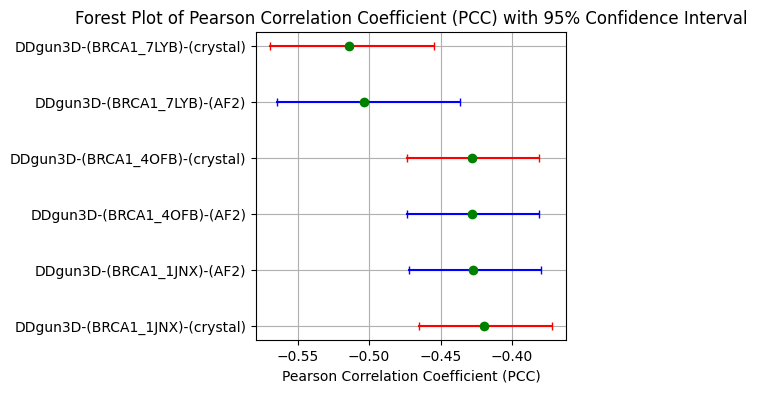

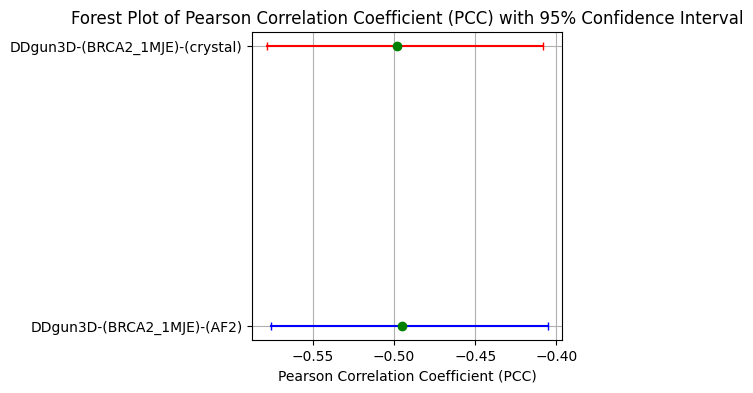

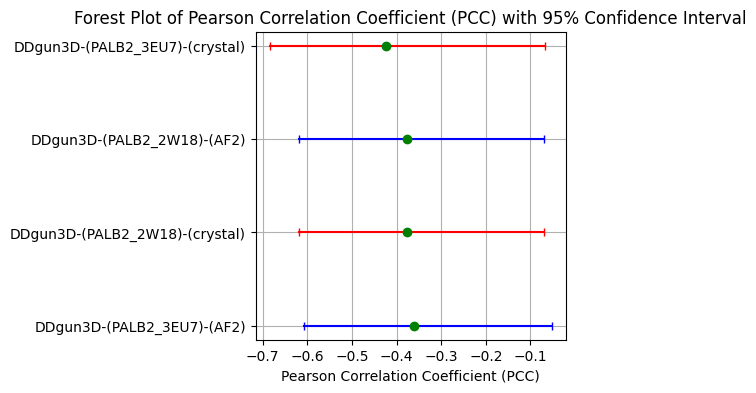

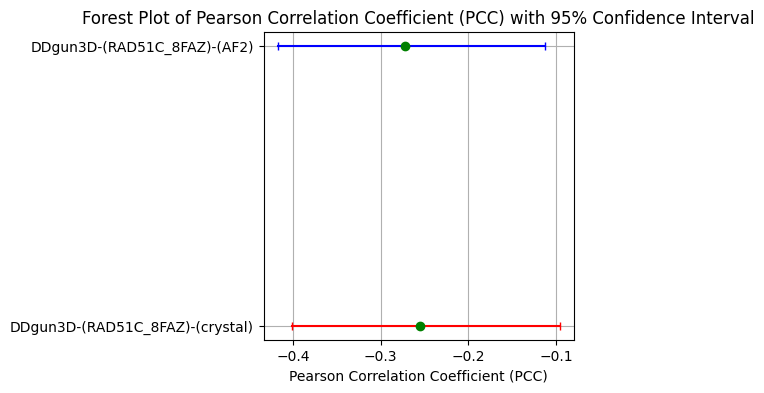

In [31]:
complex_colors = {'AF2': 'blue', 'crystal': 'red'}

# Create the figure
plt.figure(figsize=(4, 4))

# Iterate over each gene
for gene in genes:
    # Filter data for the current gene
    pcc_gene_df = pcc_ddgun_df[pcc_ddgun_df['GENE'] == gene]
    plt.figure(figsize=(4, 4))
    # Plot for the current gene with its color
    for idx, row in enumerate(pcc_gene_df.values):
  
        plt.plot([row[4], row[3]], [idx, idx], marker='|', color=complex_colors[row[6]])  
        plt.plot(row[1], idx, marker='o', color='green')  

    plt.yticks(range(len(pcc_gene_df)), [f"{row[0]}-({row[5]})-({row[6]})" for row in pcc_gene_df.values])
    
    # Set common x-label and title
    plt.xlabel('Pearson Correlation Coefficient (PCC)')
    plt.title('Forest Plot of Pearson Correlation Coefficient (PCC) with 95% Confidence Interval')
    
    # Show grid
    plt.grid(True)
    
    # Show the plot
    plt.show()


/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/seaborn/axisgrid.py:806: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/seaborn/axisgrid.py:806: UserWarning: marker is redundantly defined by the 'marker' keyword argument an

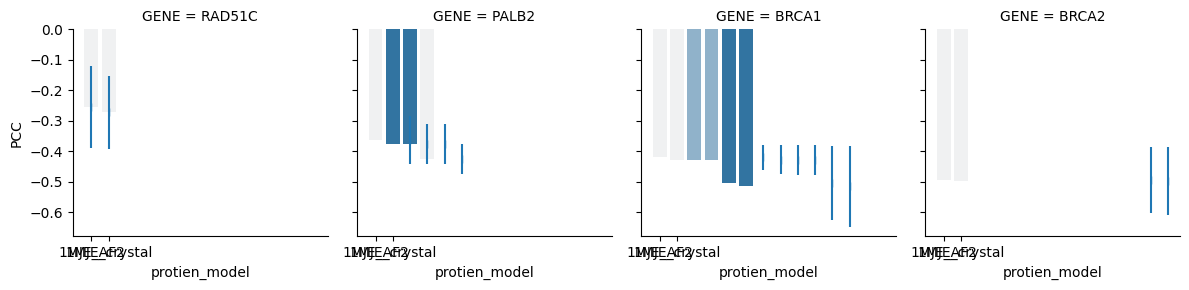

In [32]:

#all_data = []
pcc_ddgun_df['protien_model'] = pcc_ddgun_df['PDB'] + '_' + pcc_ddgun_df['COMPLEX']
pcc_ddgun_df


g = sns.FacetGrid(pcc_ddgun_df, col="GENE", height=3, col_wrap=4)
g.map_dataframe(sns.barplot, y='PCC', x='protien_model', hue='PDB', dodge=False)
g.map(plt.errorbar, "protien_model", "PCC", "err", marker="|", fmt='o')

#for ax in g.axes.flat:
#    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#g.set_titles("{col_name}")

# Add legend
#g.add_legend()

# Adjust spacing between plots
#plt.subplots_adjust(top=0.9)  # Add space for titles

# Show the plot
#plt.show()

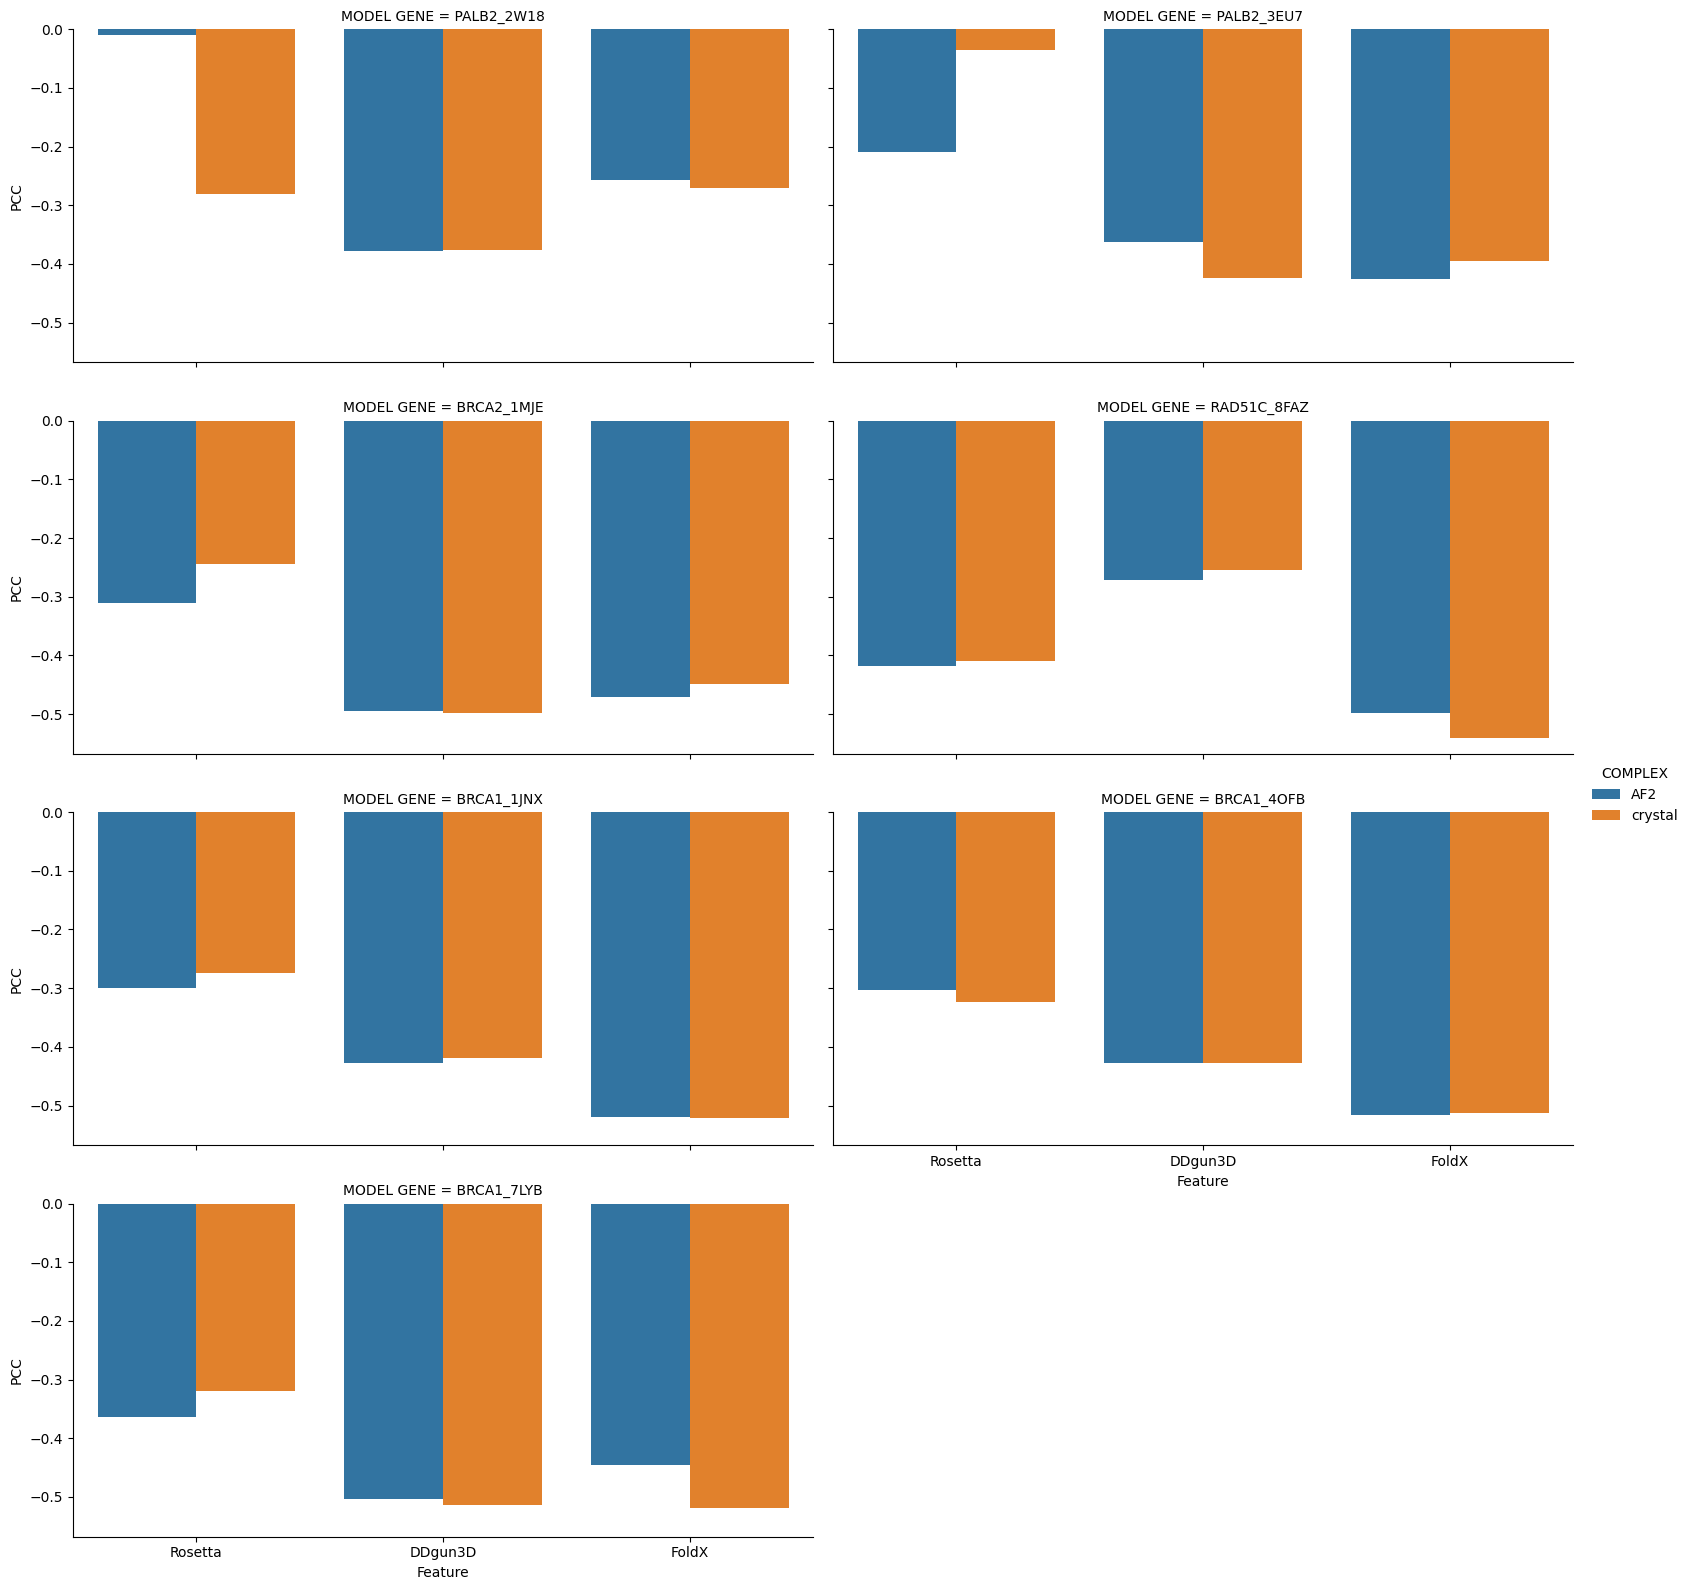

In [33]:
# Create the grouped forest plot
# Create the grouped bar plot
yerr_lower = pcc_df['PCC'] - pcc_df['Lower Bound']
yerr_upper = pcc_df['Upper Bound'] - pcc_df['PCC']

yerr = [yerr_lower, yerr_upper]
yerr = [yerr_lower.values.reshape(1, -1), yerr_upper.values.reshape(1, -1)]
g= sns.catplot(data=pcc_df, x='Feature', y='PCC', hue='COMPLEX', col='MODEL GENE', kind='bar', 
                height=4, aspect=2, ci=None, col_wrap=2, 
                errcolor='black', errwidth=1, capsize=0.1)


#g.map_dataframe(errplot, "day", "mean", "sem")


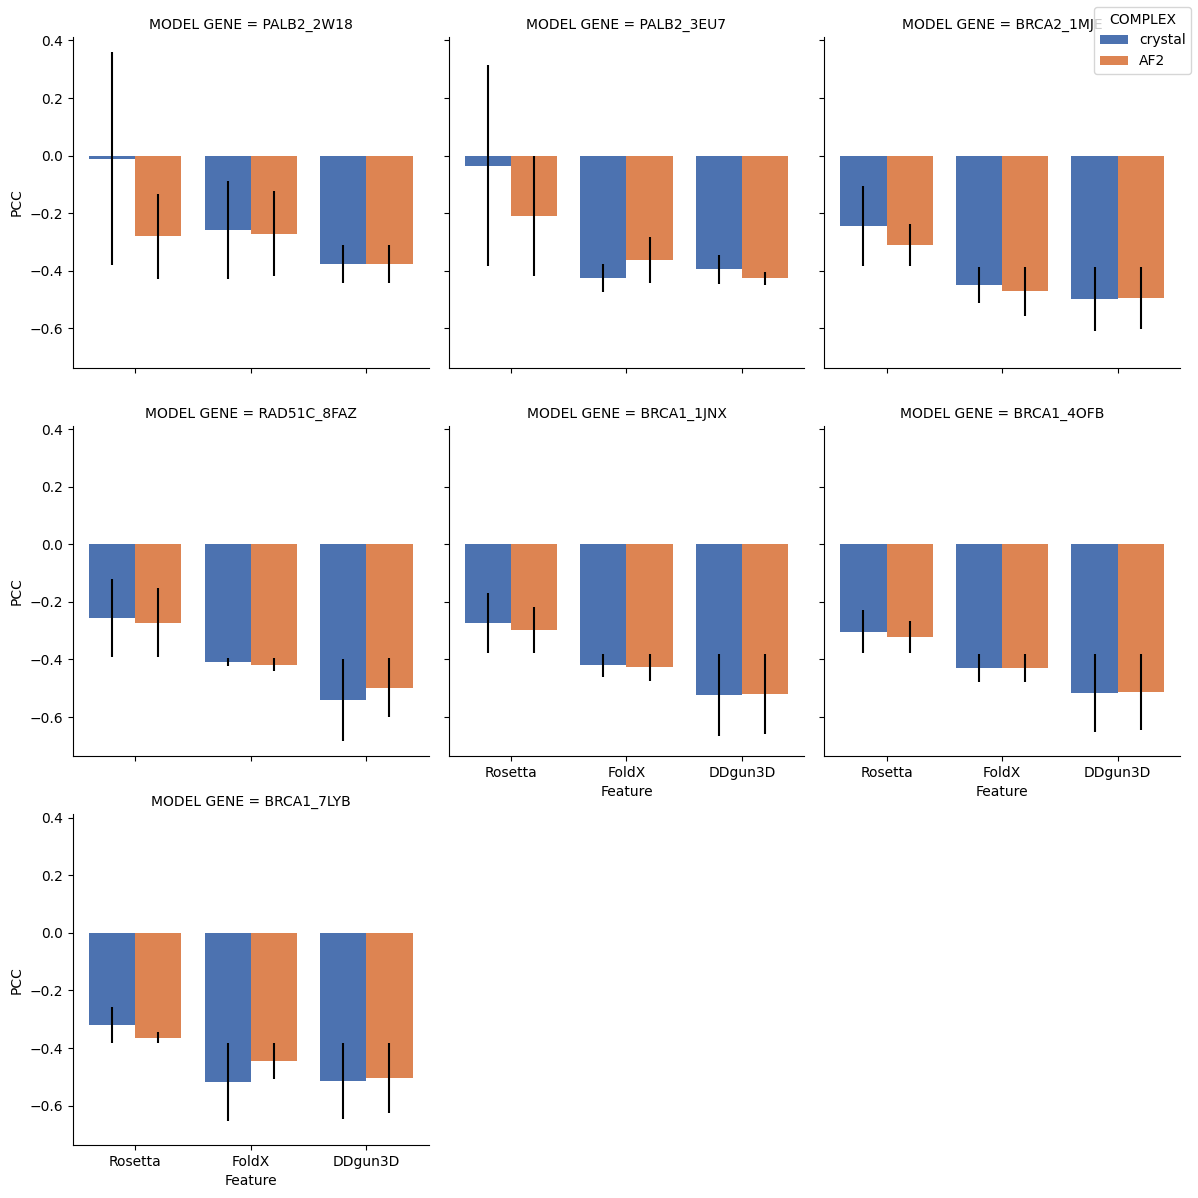

In [34]:
def errplot(x, y, data, hue, yerr, palette='deep', color=None):
    hues = data[hue].unique()
    dodge_width = 0.8
    dodge_vals = np.linspace(-dodge_width / 2, dodge_width / 2, len(hues)*2+1)[1::2]
    colors = sns.color_palette(palette, len(hues))
    xs = np.arange(len(data[x].unique()))  # Calculate x positions
    for hue_val, dodge_val, c in zip(hues, dodge_vals, colors):
        ys = [data[(data[x] == xi) & (data[hue] == hue_val)][y].to_numpy()[0] for xi in data[x].unique()]
        yerrs = [data[(data[x] == xi) & (data[hue] == hue_val)][yerr].to_numpy()[0] for xi in data[x].unique()]
        plt.bar(x=xs + dodge_val, height=ys, yerr=yerrs, width=dodge_width / len(hues), color=c, label=hue_val)
    plt.xticks(xs, data[x].unique())

g = sns.FacetGrid(pcc_df, col="MODEL GENE", height=4, col_wrap=3)
g.map_dataframe(errplot, "Feature", "PCC", hue="COMPLEX", yerr="err")
g.fig.legend(*g.axes.flat[-1].get_legend_handles_labels(), title='COMPLEX')
plt.show()

In [35]:
ddg_results_nofunction_df = ddg_results_df[['mutations', 'GENE_MODEL', 'predictor', 'dtype','struct_type', 'struct_predictor', 'ΔΔG']]
ddg_results_nofunction_df = ddg_results_nofunction_df[(ddg_results_nofunction_df['struct_type'] == 'complex') |
                                                     (ddg_results_nofunction_df['GENE_MODEL'] == 'BRCA1_1JNX') |
                                                      (ddg_results_nofunction_df['GENE_MODEL'] == 'PALB2_2W18')]

pivot_df = ddg_results_nofunction_df.pivot_table(index=['mutations', 'GENE_MODEL'], columns=['predictor', 'struct_predictor'], values='ΔΔG', aggfunc='first').reset_index()

#print(pivot_df)
pivot_df.columns = ['{}_{}'.format(col[0], col[1]) if col[1] != '' else col[0] for col in pivot_df.columns]
pivot_df = pivot_df.dropna()
def compute_deltas(df, column1, column2, name):
    df[name] = df[column1] - df[column2]
    return df

pivot_delta_df = compute_deltas(pivot_df, 'FoldX_AF2', 'FoldX_crystal', 'delta_FoldX')
pivot_delta_df = compute_deltas(pivot_delta_df, 'DDgun3D_AF2', 'DDgun3D_crystal', 'delta_DDgun3D')
pivot_delta_df = compute_deltas(pivot_delta_df, 'Rosetta_AF2', 'Rosetta_crystal', 'delta_Rosetta')
pivot_delta_df['REF_POS'] = pivot_delta_df['mutations'].str[:-1]

pivot_delta_df
#missing_df = pivot_df[pivot_df['Rosetta_AF2'].isna()][['mutations', 'GENE_MODEL', 'Rosetta_AF2']]
#missing_df
#missing_df.to_csv("missing_Rosetta_data_AF2.csv", index=None)

,mutations,GENE_MODEL,DDgun3D_AF2,DDgun3D_crystal,FoldX_AF2,FoldX_crystal,Rosetta_AF2,Rosetta_crystal,delta_FoldX,delta_DDgun3D,delta_Rosetta,REF_POS
0,A1017A,PALB2_2W18,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,1.314746e-12,0.000000e+00,0.0,-1.314746e-12,A1017
1,A1017A,PALB2_3EU7,0.0,0.0,3.410608e-13,2.273740e-14,0.000000,0.000000e+00,3.183234e-13,0.0,0.000000e+00,A1017
2,A1017C,PALB2_2W18,0.6,0.6,1.840403e-01,3.376808e-01,8.851464,4.199051e+01,-1.536405e-01,0.0,-3.313905e+01,A1017
3,A1017C,PALB2_3EU7,0.6,0.7,3.607872e-02,5.104160e-01,3.873989,3.843509e+00,-4.743373e-01,-0.1,3.048024e-02,A1017
4,A1017D,PALB2_2W18,3.2,3.1,4.822120e+00,2.475000e+00,29.227621,4.154309e+01,2.347120e+00,0.1,-1.231547e+01,A1017
...,...,...,...,...,...,...,...,...,...,...,...,...
42458,Y929V,PALB2_3EU7,0.4,0.4,3.042432e-01,3.258472e-01,1.357790,9.106499e-01,-2.160400e-02,0.0,4.471397e-01,Y929
42459,Y929W,PALB2_2W18,0.1,0.1,3.017496e-01,2.321112e-01,1.440396,1.501954e+00,6.963840e-02,0.0,-6.155721e-02,Y929
42460,Y929W,PALB2_3EU7,0.1,0.1,1.093089e-01,1.112374e+00,1.333113,4.394165e+00,-1.003065e+00,0.0,-3.061053e+00,Y929
42461,Y929Y,PALB2_2W18,0.0,0.0,3.088532e-03,3.018550e-03,0.000000,0.000000e+00,6.998174e-05,0.0,0.000000e+00,Y929


PALB2_2W18 0.7355565267491755 0.857645921548733 0.0 5832 0.8908248792563597 0.3413694409813406 (0.8771111767597699, 0.9045385817529494)
BRCA1_1JNX 0.8591963858227136 0.926928468557695 0.0 4139 0.8562815226931544 0.2040762302095156 (0.8457155456313875, 0.8668474997549213)
BRCA1_4OFB 0.9122280481881218 0.9551063020356015 0.0 4179 0.8974919892896994 0.08496268547955665 (0.8890470124223561, 0.9059369661570428)
RAD51C_8FAZ 0.7942620599351723 0.8912138126932124 0.0 6279 1.1993949365251289 0.05538062073299921 (1.1842908914432941, 1.2144989816069636)
PALB2_3EU7 0.8789433957501542 0.9375198108574315 0.0 5045 0.8694181482803783 0.17075886054355482 (0.8605107607985873, 0.8783255357621693)
BRCA2_1MJE 0.5115349038662393 0.7152166831570971 0.0 11849 0.7417969805240617 0.3644057121121922 (0.7287427143912144, 0.7548512466569091)
BRCA1_7LYB 0.22991131562711728 0.4794906835665499 4.894170767209701e-83 1429 0.6462879003975049 0.8936462292435983 (0.5848663405019827, 0.7077094602930272)


/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/seaborn/axisgrid.py:806: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/seaborn/axisgrid.py:806: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/seaborn/axisgrid.py:806: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args

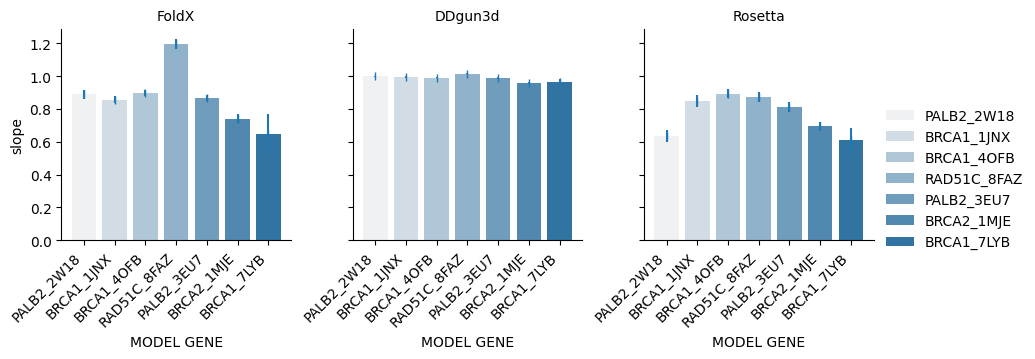

In [36]:
from scipy.stats import linregress

pcc_ddg_df = pd.DataFrame(columns=['MODEL GENE', 'PCC', 'P-Value', 'Lower Bound', 'Upper Bound'])

def spearmanr_ci(x, y, alpha=0.05):
    r, p = stats.spearmanr(x, y)
    n = len(x)
    r_z = np.arctanh(r)
    se = 1 / np.sqrt(x.size - 3)
    z = stats.norm.ppf(1 - alpha / 2)
    lo_z, hi_z = r_z - z * se, r_z + z * se
    lo, hi = np.tanh((lo_z, hi_z))
    err = (hi - p) + (p - lo)
    return r, p, lo, hi,n, err

def compute_r2_p(df, col1, col2):
    data = df[[col1, col2]].dropna()
    total = len(data)
    slope, intercept, r_value, p_value, std_err = linregress(data[col1], data[col2])
    r_squared = r_value ** 2
    
    # Compute confidence interval for slope and intercept
    # 95% confidence interval
    from scipy.stats import t
    t_value = t.ppf(0.975, df=len(data) - 2)  # Two-tailed t-test, alpha = 0.05
    slope_ci = (slope - t_value * std_err, slope + t_value * std_err)
    intercept_ci = (intercept - t_value * std_err, intercept + t_value * std_err)
    return r_squared, r_value, p_value, total, slope, intercept, slope_ci
    
model_list = list(set(pivot_delta_df.GENE_MODEL.tolist()))
for model in model_list:
    model_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == model]
    #print(model_df)
    r_squared, r_value, p_value, total, slope, intercept, slope_ci = compute_r2_p(model_df,
                                                                                  'FoldX_AF2',
                                                                                  'FoldX_crystal')
    print(model, r_squared, r_value, p_value, total, slope, intercept, slope_ci )
    pcc_ddg_df = pcc_ddg_df.append({'MODEL GENE': model, 
                                        'PCC': r_value,
                                        'P-Value': p_value,
                                        'slope': slope,
                                        'total': total,
                                        'Lower Bound': slope_ci[0],
                                        'Upper Bound': slope_ci[1], 
                                        'predictor': 'FoldX'}, ignore_index=True)

    
for model in model_list:
    model_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == model]
    r_squared, r_value, p_value, total, slope, intercept, slope_ci = compute_r2_p(model_df, 'DDgun3D_AF2',
                                                                                  'DDgun3D_crystal')
    #print(model, r_squared, r_value, p_value, total, slope, intercept, slope_ci )
    pcc_ddg_df = pcc_ddg_df.append({'MODEL GENE': model, 
                                        'PCC': r_value,
                                        'P-Value': p_value,
                                        'slope': slope,
                                        'total': total,
                                        'Lower Bound': slope_ci[0],
                                        'Upper Bound': slope_ci[1], 
                                        'predictor': 'DDgun3d'}, ignore_index=True)

    
for model in model_list:
    model_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == model]
    r_squared, r_value, p_value, total, slope, intercept, slope_ci  = compute_r2_p(model_df,
                                                                                   'Rosetta_AF2',
                                                                                   'Rosetta_crystal')
    #print(model, r_squared, r_value, p_value, total, slope, intercept, slope_ci )
    pcc_ddg_df = pcc_ddg_df.append({'MODEL GENE': model, 
                                        'PCC': r_value,
                                        'P-Value': p_value,
                                        'slope': slope,
                                        'total': total,
                                        'Lower Bound': slope_ci[0],
                                        'Upper Bound': slope_ci[1], 
                                        'predictor': 'Rosetta'}, ignore_index=True)

pcc_ddg_df['CI'] =   (pcc_ddg_df['Upper Bound'] - pcc_ddg_df['slope']) + (pcc_ddg_df['slope'] - pcc_ddg_df['Lower Bound'])
#pcc_ddg_df
g = sns.FacetGrid(pcc_ddg_df, col="predictor", height=3, col_wrap=3)
g.map_dataframe(sns.barplot, y='slope', x='MODEL GENE', hue='MODEL GENE', dodge=False)
g.map(plt.errorbar, "MODEL GENE", "slope", "CI", marker="|", fmt='o')

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
g.set_titles("{col_name}")

# Add legend
g.add_legend()

# Adjust spacing between plots
plt.subplots_adjust(top=0.9)  # Add space for titles

# Show the plot
plt.show()

     MODEL GENE       PCC        P-Value  Lower Bound  Upper Bound predictor  \
0    PALB2_2W18  0.857646   0.000000e+00     0.877111     0.904539     FoldX   
1    BRCA1_1JNX  0.926928   0.000000e+00     0.845716     0.866847     FoldX   
2    BRCA1_4OFB  0.955106   0.000000e+00     0.889047     0.905937     FoldX   
3   RAD51C_8FAZ  0.891214   0.000000e+00     1.184291     1.214499     FoldX   
4    PALB2_3EU7  0.937520   0.000000e+00     0.860511     0.878326     FoldX   
5    BRCA2_1MJE  0.715217   0.000000e+00     0.728743     0.754851     FoldX   
6    BRCA1_7LYB  0.479491   4.894171e-83     0.584866     0.707709     FoldX   
7    PALB2_2W18  0.996193   0.000000e+00     0.997569     1.002062   DDgun3d   
8    BRCA1_1JNX  0.995518   0.000000e+00     0.990061     0.995811   DDgun3d   
9    BRCA1_4OFB  0.998481   0.000000e+00     0.989200     0.992517   DDgun3d   
10  RAD51C_8FAZ  0.997306   0.000000e+00     1.014819     1.018519   DDgun3d   
11   PALB2_3EU7  0.997314   0.000000e+00

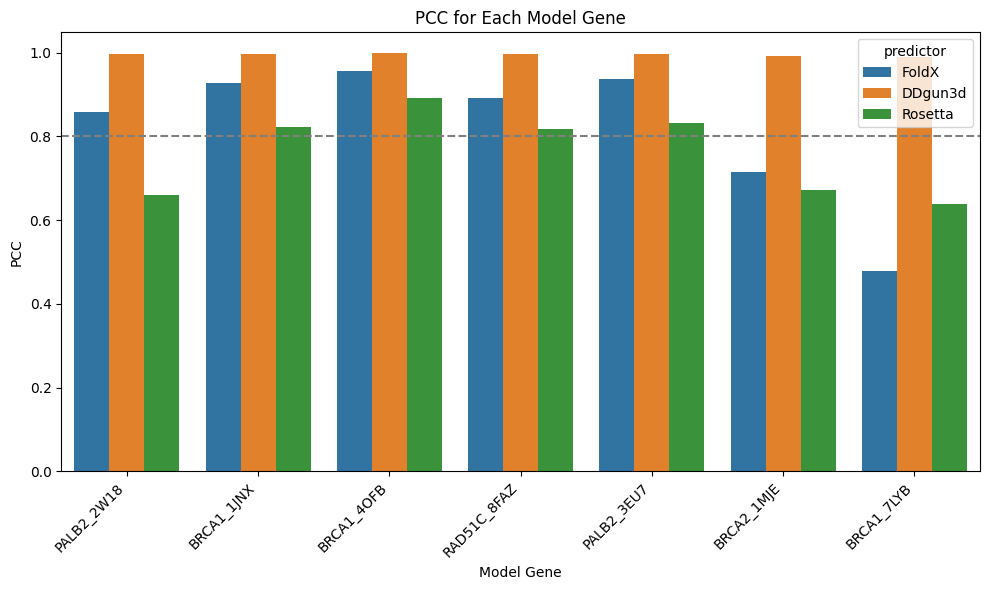

In [37]:
#sns.barplot(data=pcc_ddg_df, x='MODEL_GENE', y='PCC')
print(pcc_ddg_df)
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.barplot(data=pcc_ddg_df, x='MODEL GENE', y='PCC', hue='predictor')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0.80, color='gray', linestyle='--')
# Set labels and title
plt.xlabel('Model Gene')
plt.ylabel('PCC')
plt.title('PCC for Each Model Gene')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

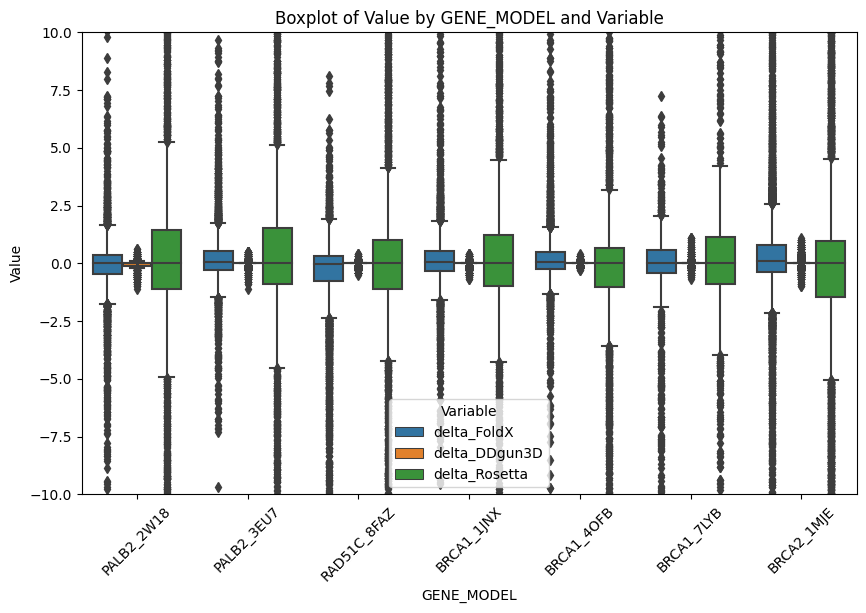

,mutations,GENE_MODEL,DDgun3D_AF2,DDgun3D_crystal,FoldX_AF2,FoldX_crystal,Rosetta_AF2,Rosetta_crystal,delta_FoldX,delta_DDgun3D,delta_Rosetta,REF_POS
0,A1017A,PALB2_2W18,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,1.314746e-12,0.000000e+00,0.0,-1.314746e-12,A1017
1,A1017A,PALB2_3EU7,0.0,0.0,3.410608e-13,2.273740e-14,0.000000,0.000000e+00,3.183234e-13,0.0,0.000000e+00,A1017
2,A1017C,PALB2_2W18,0.6,0.6,1.840403e-01,3.376808e-01,8.851464,4.199051e+01,-1.536405e-01,0.0,-3.313905e+01,A1017
3,A1017C,PALB2_3EU7,0.6,0.7,3.607872e-02,5.104160e-01,3.873989,3.843509e+00,-4.743373e-01,-0.1,3.048024e-02,A1017
4,A1017D,PALB2_2W18,3.2,3.1,4.822120e+00,2.475000e+00,29.227621,4.154309e+01,2.347120e+00,0.1,-1.231547e+01,A1017
...,...,...,...,...,...,...,...,...,...,...,...,...
42458,Y929V,PALB2_3EU7,0.4,0.4,3.042432e-01,3.258472e-01,1.357790,9.106499e-01,-2.160400e-02,0.0,4.471397e-01,Y929
42459,Y929W,PALB2_2W18,0.1,0.1,3.017496e-01,2.321112e-01,1.440396,1.501954e+00,6.963840e-02,0.0,-6.155721e-02,Y929
42460,Y929W,PALB2_3EU7,0.1,0.1,1.093089e-01,1.112374e+00,1.333113,4.394165e+00,-1.003065e+00,0.0,-3.061053e+00,Y929
42461,Y929Y,PALB2_2W18,0.0,0.0,3.088532e-03,3.018550e-03,0.000000,0.000000e+00,6.998174e-05,0.0,0.000000e+00,Y929


In [38]:
pivot_delta_delta_df = pivot_delta_df[['GENE_MODEL', 'delta_FoldX', 'delta_DDgun3D', 'delta_Rosetta']]
pivot_delta_delta_melt_df = pd.melt(pivot_delta_delta_df, id_vars=['GENE_MODEL'])
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Create the boxplot
sns.boxplot(data=pivot_delta_delta_melt_df, x='GENE_MODEL', y='value', hue='variable')



plt.ylim(-10, 10)

# Set labels and title
plt.xlabel('GENE_MODEL')
plt.ylabel('Value')
plt.title('Boxplot of Value by GENE_MODEL and Variable')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show legend
plt.legend(title='Variable')

# Show the plot
plt.show()
pivot_delta_df

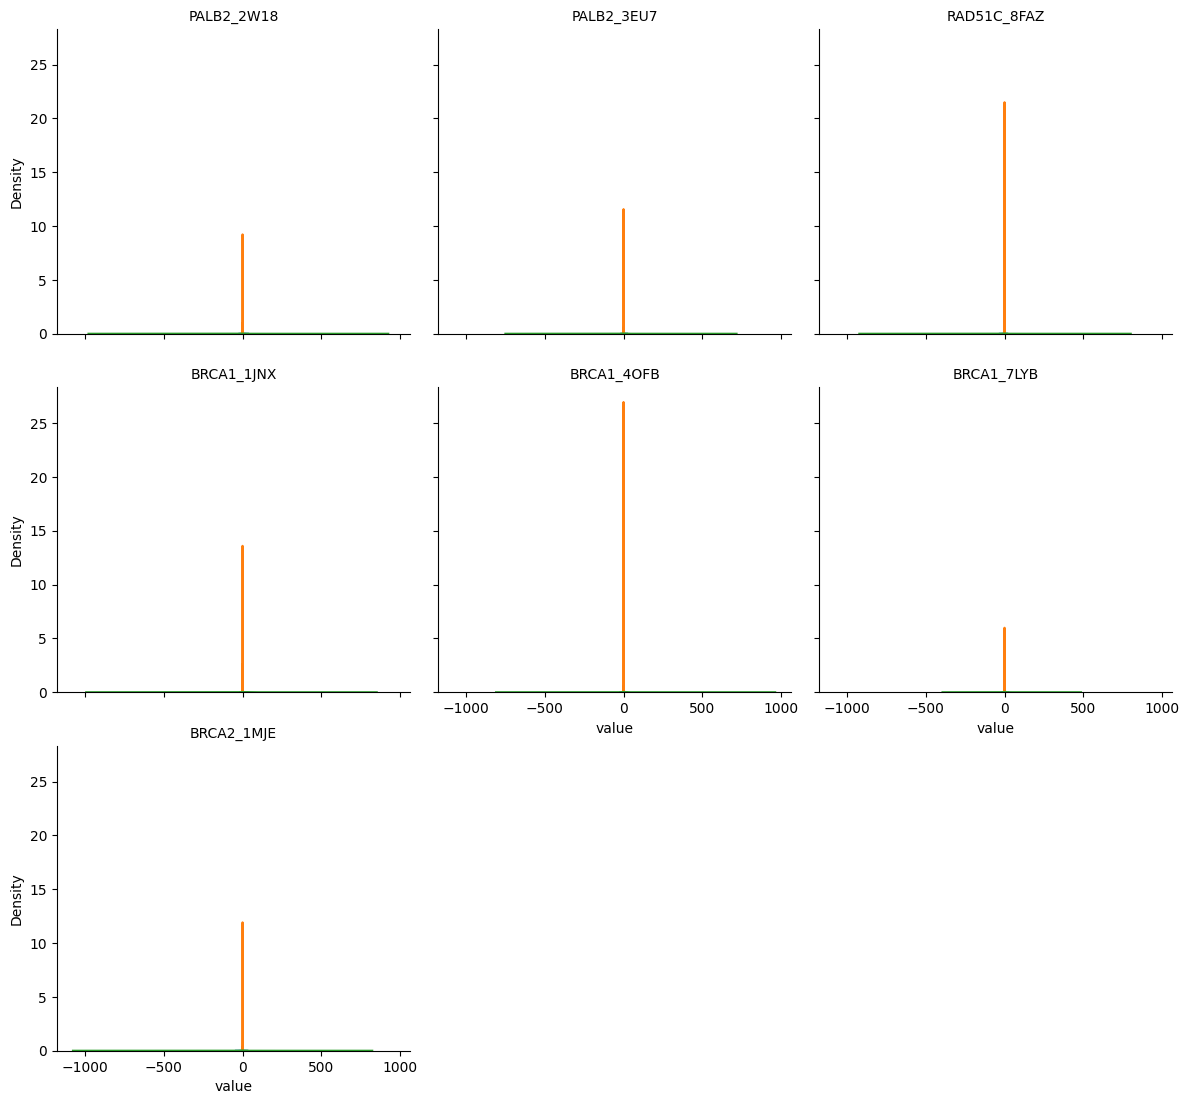

,GENE_MODEL,variable,value
0,PALB2_2W18,delta_FoldX,0.000000e+00
1,PALB2_3EU7,delta_FoldX,3.183234e-13
2,PALB2_2W18,delta_FoldX,-1.536405e-01
3,PALB2_3EU7,delta_FoldX,-4.743373e-01
4,PALB2_2W18,delta_FoldX,2.347120e+00
...,...,...,...
116251,PALB2_3EU7,delta_Rosetta,4.471397e-01
116252,PALB2_2W18,delta_Rosetta,-6.155721e-02
116253,PALB2_3EU7,delta_Rosetta,-3.061053e+00
116254,PALB2_2W18,delta_Rosetta,0.000000e+00


In [39]:
g = sns.FacetGrid(pivot_delta_delta_melt_df, col="GENE_MODEL", hue="variable", col_wrap=3, height=4)

# Map kdeplot onto the grid
g.map_dataframe(sns.kdeplot, "value")

# Set titles for each subplot
g.set_titles("{col_name}")

# Adjust spacing between plots
plt.subplots_adjust(top=0.9)  # Add space for titles

# Show the plot
plt.show()

pivot_delta_delta_melt_df

In [40]:


# Define a function to calculate the molecular weight of an amino acid
def calculate_molecular_weight(aa):
    # Return the molecular weight of the amino acid
    protein = ProteinAnalysis(aa) 
    molecular_weight = protein.molecular_weight()
    return molecular_weight

def calculate_aromaticity(aa):
    # Return the molecular weight of the amino acid
    protein = ProteinAnalysis(aa) 
    aromaticity = protein.aromaticity()
    return aromaticity


def calculate_instability_index(aa):
    # Return the molecular weight of the amino acid
    protein = ProteinAnalysis(aa) 
    instability_index = protein.instability_index()
    return instability_index

def calculate_flexibility(aa):
    # Return the molecular weight of the amino acid
    protein = ProteinAnalysis(aa) 
    flexibility = protein.flexibility()
    return flexibility

def calculate_isoelectric_point(aa):
    # Return the molecular weight of the amino acid
    protein = ProteinAnalysis(aa) 
    isoelectric_point = protein.isoelectric_point()
    return isoelectric_point

def calculate_gravy(aa):
    # Return the molecular weight of the amino acid
    protein = ProteinAnalysis(aa) 
    gravy = protein.gravy()
    return gravy

def generate_properties(df):
    df['AA_weight'] = df['Amino_acid'].apply(lambda x: calculate_molecular_weight(x))
    df['aromaticity'] = df['Amino_acid'].apply(lambda x: calculate_aromaticity(x))
#BRCA1_1JNX_features_df['flexibility'] = BRCA1_1JNX_features_df['Amino_acid'].apply(lambda x: calculate_flexibility(x))
    df['isoelectric_point'] = df['Amino_acid'].apply(lambda x: calculate_isoelectric_point(x))
    df['gravy'] = df['Amino_acid'].apply(lambda x: calculate_gravy(x))
    df['instability_index'] = df['Amino_acid'].apply(lambda x: calculate_instability_index(x))
    return df

In [41]:
BRCA1_4OFB_features_df = pd.read_csv("BRCA1_4OFB_plddt_distance.csv", sep='\t')
BRCA1_7LYB_features_df = pd.read_csv("BRCA1_7LYB_plddt_distance.csv", sep='\t')
BRCA1_1JNX_features_df = pd.read_csv("BRCA1_1JNX_plddt_distance.csv", sep='\t')
BRCA2_1MJE_features_df = pd.read_csv("BRCA2_1MJE_plddt_distance.csv", sep='\t')
PALB2_3EU7_features_df = pd.read_csv("PALB2_3EU7_plddt_distance.csv", sep='\t')
RAD51C_8FAZ_features_df = pd.read_csv("RAD51C_8FAZ_plddt_distance.csv", sep='\t')
PALB2_2W18_features_df = pd.read_csv("PALB2_2W18_plddt_distance.csv", sep='\t')

BRCA1_4OFB_features_df = generate_properties(BRCA1_4OFB_features_df) 
BRCA1_7LYB_features_df = generate_properties(BRCA1_7LYB_features_df)
BRCA1_1JNX_features_df = generate_properties(BRCA1_1JNX_features_df)
BRCA2_1MJE_features_df = generate_properties(BRCA2_1MJE_features_df)
PALB2_3EU7_features_df = generate_properties(PALB2_3EU7_features_df)
RAD51C_8FAZ_features_df = generate_properties(RAD51C_8FAZ_features_df)
PALB2_2W18_features_df = generate_properties(PALB2_2W18_features_df)

['A1669Y', 'A1708H', 'A1708W', 'A1752D', 'A1752F', 'A1752P', 'A1752W', 'A1752Y', 'A1789H', 'A1789K', 'A1789M', 'A1789Q', 'A1789W', 'A1789Y', 'A1814P', 'A1843K', 'A1843R', 'C1768W', 'C1768Y', 'C1787W', 'C1828F', 'C1828H', 'C1828W', 'C1828Y', 'D1739W', 'E1765F', 'E1765H', 'F1704W', 'G1738W', 'G1748E', 'G1748H', 'G1748I', 'G1748L', 'G1748Q', 'G1748R', 'G1748T', 'G1748W', 'G1748Y', 'G1770C', 'G1770D', 'G1770E', 'G1770F', 'G1770H', 'G1770I', 'G1770K', 'G1770L', 'G1770M', 'G1770N', 'G1770P', 'G1770Q', 'G1770R', 'G1770T', 'G1770V', 'G1770W', 'G1770Y', 'G1788H', 'G1788W', 'G1801P', 'I1707F', 'I1707K', 'I1707W', 'I1760W', 'I1766W', 'I1824Y', 'L1657W', 'L1676R', 'L1676W', 'L1780W', 'L1780Y', 'L1839W', 'M1652F', 'M1652W', 'M1652Y', 'M1689H', 'M1689W', 'M1775F', 'M1775W', 'M1775Y', 'M1783W', 'M1827P', 'N1742F', 'N1742W', 'R1699A', 'R1699C', 'R1699D', 'R1699E', 'R1699F', 'R1699G', 'R1699H', 'R1699I', 'R1699N', 'R1699Q', 'R1699S', 'R1699T', 'R1699V', 'R1699W', 'R1699Y', 'S1651F', 'S1651Y', 'S1655R',

<AxesSubplot:xlabel='POS', ylabel='delta_FoldX'>

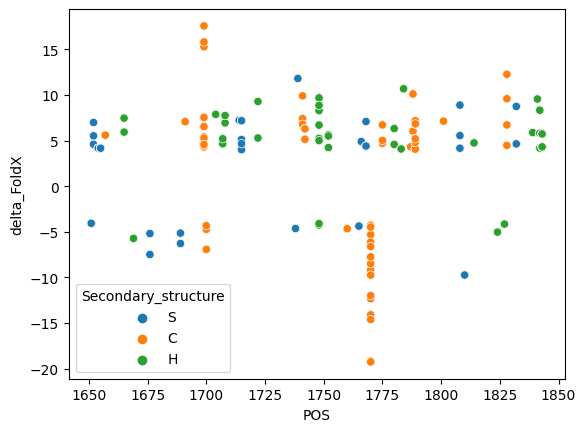

In [42]:
BRCA1_ddg_4OFB_results_df = ddg_results_df[ddg_results_df['model'] =='4OFB']
BRCA1_4OFB_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "BRCA1_4OFB"]
BRCA1_ddg_4OFB_results_feature_df = pd.merge(BRCA1_4OFB_features_df, BRCA1_4OFB_delta_df, on='REF_POS')


BRCA1_ddg_4OFB_results_feature_df.columns
metrics_column = ['PLDDT', 'Relative_ASA', 'Mean_Distance', 
                   'AA_weight', 'aromaticity',
                 'isoelectric_point', 'gravy', 'delta_FoldX', 
                  'delta_DDgun3D', 'delta_Rosetta']

BRCA1_4OFB_feature_only_df = BRCA1_ddg_4OFB_results_feature_df[metrics_column]
BRCA1_4OFB_feature_only_df = BRCA1_4OFB_feature_only_df.drop_duplicates()
BRCA1_4OFB_feature_only_df = BRCA1_4OFB_feature_only_df.reset_index()
BRCA1_4OFB_feature_only_df

corr = BRCA1_4OFB_feature_only_df.corr()

# Create a heatmap
#plt.figure(figsize=(10, 8))
##sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
#plt.title('Correlation Heatmap')
#plt.show()

#BRCA1_ddg_4OFB_results_feature_df

BRCA1_ddg_4OFB_results_feature_df['alt_AA'] = BRCA1_ddg_4OFB_results_feature_df['mutations'].str[-1]
BRCA1_ddg_4OFB_results_feature_df['ref_AA'] = BRCA1_ddg_4OFB_results_feature_df['mutations'].str[0]
BRCA1_ddg_4OFB_results_feature_df['POS'] = BRCA1_ddg_4OFB_results_feature_df['mutations'].apply(lambda x: extract_integers(x)[0])
#BRCA1_ddg_7LYB_results_feature_df['POS'] = BRCA1_ddg_7LYB_results_feature_df['POS'].astype(int)
BRCA1_ddg_4OFB_results_feature_df['alt_Aromatic_AA'] = BRCA1_ddg_4OFB_results_feature_df['alt_AA'].apply(lambda x: 1 if x in aro_aa else 0)
BRCA1_ddg_4OFB_results_feature_df['ref_Aromatic_AA'] = BRCA1_ddg_4OFB_results_feature_df['ref_AA'].apply(lambda x: 1 if x in aro_aa else 0)
BRCA1_ddg_4OFB_results_feature_df


large_4OFB_df = BRCA1_ddg_4OFB_results_feature_df[(BRCA1_ddg_4OFB_results_feature_df['delta_FoldX'] > 4) |
                                             (BRCA1_ddg_4OFB_results_feature_df['delta_FoldX'] < -4)]
#large_4OFB_df

print(sorted(list(set(large_4OFB_df.mutations.tolist()))))

sns.scatterplot(data=large_4OFB_df, y='delta_FoldX', x= "POS", hue='Secondary_structure' )
#BRCA1_ddg_7LYB_results_feature_df
#large_filter_df = large_df[["ref_AA", 'POS','Mean_Distance', 'PLDDT' ]]
#large_filter_df = large_filter_df.drop_duplicates()
#large_filter_df

['A5P', 'A92I', 'C24A', 'C24D', 'C24E', 'C24F', 'C24G', 'C24H', 'C24I', 'C24K', 'C24L', 'C24M', 'C24N', 'C24P', 'C24Q', 'C24R', 'C24S', 'C24T', 'C24V', 'C27A', 'C27D', 'C27E', 'C27F', 'C27G', 'C27H', 'C27I', 'C27K', 'C27L', 'C27M', 'C27N', 'C27P', 'C27Q', 'C27R', 'C27S', 'C27T', 'C27V', 'C44A', 'C44E', 'C44F', 'C44G', 'C44H', 'C44I', 'C44K', 'C44L', 'C44M', 'C44N', 'C44P', 'C44Q', 'C44R', 'C44S', 'C44T', 'C44V', 'C47A', 'C47E', 'C47F', 'C47G', 'C47H', 'C47I', 'C47K', 'C47L', 'C47M', 'C47N', 'C47P', 'C47Q', 'C47R', 'C47S', 'C47T', 'C47V', 'C61A', 'C61E', 'C61F', 'C61G', 'C61H', 'C61I', 'C61K', 'C61L', 'C61M', 'C61N', 'C61P', 'C61Q', 'C61R', 'C61S', 'C61T', 'C61V', 'C64A', 'C64E', 'C64F', 'C64G', 'C64H', 'C64I', 'C64K', 'C64L', 'C64M', 'C64N', 'C64P', 'C64Q', 'C64R', 'C64S', 'C64T', 'C64V', 'D96F', 'D96G', 'D96H', 'D96I', 'D96K', 'D96L', 'D96R', 'D96V', 'F93P', 'H41A', 'H41F', 'H41G', 'H41I', 'H41K', 'H41L', 'H41M', 'H41P', 'H41Q', 'H41R', 'H41S', 'H41T', 'H41V', 'I31F', 'I31H', 'I68D', 

<AxesSubplot:xlabel='POS', ylabel='delta_FoldX'>

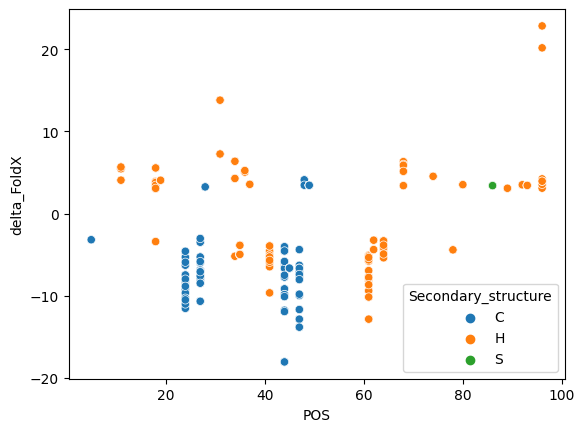

In [43]:


BRCA1_ddg_7LYB_results_df = ddg_results_df[ddg_results_df['model'] =='7LYB']
BRCA1_7LYB_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "BRCA1_7LYB"]
BRCA1_ddg_7LYB_results_feature_df = pd.merge(BRCA1_7LYB_features_df, BRCA1_7LYB_delta_df, on='REF_POS')


BRCA1_ddg_7LYB_results_feature_df.columns
metrics_column = ['PLDDT', 'Relative_ASA', 'Mean_Distance', 
                   'AA_weight', 'aromaticity',
                 'isoelectric_point', 'gravy', 'delta_FoldX', 
                  'delta_DDgun3D', 'delta_Rosetta']

BRCA1_7LYB_feature_only_df = BRCA1_ddg_7LYB_results_feature_df[metrics_column]
BRCA1_7LYB_feature_only_df = BRCA1_7LYB_feature_only_df.drop_duplicates()
BRCA1_7LYB_feature_only_df = BRCA1_7LYB_feature_only_df.reset_index(drop=True)
BRCA1_7LYB_feature_only_df

corr = BRCA1_7LYB_feature_only_df.corr()

# Create a heatmap
#plt.figure(figsize=(10, 8))
#sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
#plt.title('Correlation Heatmap')
#plt.show()
#sns.kdeplot(BRCA1_ddg_7LYB_results_feature_df.delta_FoldX)
#large_df = BRCA1_ddg_7LYB_results_feature_df[(BRCA1_ddg_7LYB_results_feature_df['delta_FoldX'] > 4) | (BRCA1_ddg_7LYB_results_feature_df['delta_FoldX'] < -4)]

BRCA1_ddg_7LYB_results_feature_df['alt_AA'] = BRCA1_ddg_7LYB_results_feature_df['mutations'].str[-1]
BRCA1_ddg_7LYB_results_feature_df['ref_AA'] = BRCA1_ddg_7LYB_results_feature_df['mutations'].str[0]
BRCA1_ddg_7LYB_results_feature_df['POS'] = BRCA1_ddg_7LYB_results_feature_df['mutations'].apply(lambda x: extract_integers(x)[0])
#BRCA1_ddg_7LYB_results_feature_df['POS'] = BRCA1_ddg_7LYB_results_feature_df['POS'].astype(int)
BRCA1_ddg_7LYB_results_feature_df['alt_Aromatic_AA'] = BRCA1_ddg_7LYB_results_feature_df['alt_AA'].apply(lambda x: 1 if x in aro_aa else 0)
BRCA1_ddg_7LYB_results_feature_df['ref_Aromatic_AA'] = BRCA1_ddg_7LYB_results_feature_df['ref_AA'].apply(lambda x: 1 if x in aro_aa else 0)
BRCA1_ddg_7LYB_results_feature_df


large_df = BRCA1_ddg_7LYB_results_feature_df[(BRCA1_ddg_7LYB_results_feature_df['delta_FoldX'] > 3) |
                                             (BRCA1_ddg_7LYB_results_feature_df['delta_FoldX'] < -3)]

large_2df = BRCA1_ddg_7LYB_results_feature_df[BRCA1_ddg_7LYB_results_feature_df['distance'] ==2]
#sns.scatterplot(data=large_2df, y='delta_FoldX', x= "local_area_diff")
large_3df = BRCA1_ddg_7LYB_results_feature_df[BRCA1_ddg_7LYB_results_feature_df['distance'] ==3]
#sns.scatterplot(data=large_3df, y='delta_FoldX', x= "local_area_diff")

large_5df = BRCA1_ddg_7LYB_results_feature_df[BRCA1_ddg_7LYB_results_feature_df['distance'] ==5]
#sns.scatterplot(data=large_5df, y='delta_FoldX', x= "local_area_diff")

large_7df = BRCA1_ddg_7LYB_results_feature_df[BRCA1_ddg_7LYB_results_feature_df['distance'] ==7]
#sns.scatterplot(data=large_11df, y='delta_FoldX', x= "local_area_diff" )

large_9df = BRCA1_ddg_7LYB_results_feature_df[BRCA1_ddg_7LYB_results_feature_df['distance'] ==9]

large_11df = BRCA1_ddg_7LYB_results_feature_df[BRCA1_ddg_7LYB_results_feature_df['distance'] ==11]
#sns.scatterplot(data=large_df, y='delta_FoldX', x= "POS", hue='ref_Aromatic_AA' )

print(sorted(list(set(large_df.mutations.tolist()))))
#BRCA1_ddg_7LYB_results_feature_df
large_filter_df = large_df[["ref_AA", 'POS','Mean_Distance', 'PLDDT' ]]
large_filter_df = large_filter_df.drop_duplicates()
sns.scatterplot(data=large_df, y='delta_FoldX', x= "POS", hue='Secondary_structure' )
#large_df['Secondary_structure'].value_counts()

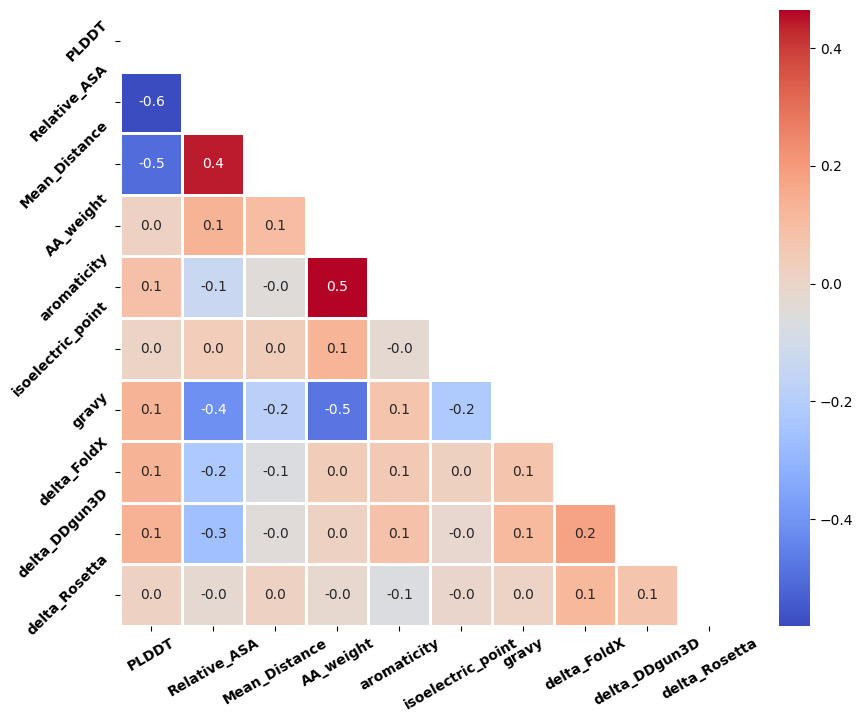

In [78]:
BRCA2_ddg_1MJE_results_df = ddg_results_df[ddg_results_df['model'] =='1MJE']
BRCA2_1MJE_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "BRCA2_1MJE"]
BRCA2_ddg_1MJE_results_feature_df = pd.merge(BRCA2_1MJE_features_df, BRCA2_1MJE_delta_df, on='REF_POS')


BRCA2_ddg_1MJE_results_feature_df.columns
metrics_column = ['PLDDT', 'Relative_ASA', 'Mean_Distance', 
                   'AA_weight', 'aromaticity',
                 'isoelectric_point', 'gravy', 'delta_FoldX', 
                  'delta_DDgun3D', 'delta_Rosetta']

BRCA2_1MJE_feature_only_df = BRCA2_ddg_1MJE_results_feature_df[metrics_column]
BRCA2_1MJE_feature_only_df = BRCA2_1MJE_feature_only_df.drop_duplicates()
BRCA2_1MJE_feature_only_df = BRCA2_1MJE_feature_only_df.reset_index(drop=True)
BRCA2_1MJE_feature_only_df

corr = BRCA2_1MJE_feature_only_df.corr(method='spearman')

mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot pyramid heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".1f", linewidths=1, mask=mask)

# Optionally, you can set a title
# plt.title('Pyramid Correlation Heatmap')

# Save the plot at 300 dpi
plt.xticks(fontweight='bold', rotation=30)  # Rotate x-axis labels by 45 degrees
plt.yticks(fontweight='bold', rotation=45) 
plt.savefig('pyramid_heatmap.png', dpi=300)

plt.show()

In [45]:
BRCA1_ddg_7LYB_results_df = ddg_results_df[ddg_results_df['model'] =='7LYB']
BRCA1_7LYB_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "BRCA1_7LYB"]
BRCA1_ddg_7LYB_results_feature_df = pd.merge(BRCA1_7LYB_features_df, BRCA1_7LYB_delta_df, on='REF_POS')

BRCA2_ddg_1MJE_results_df = ddg_results_df[ddg_results_df['model'] =='1MJE']
BRCA2_1MJE_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "BRCA2_1MJE"]
BRCA2_ddg_1MJE_results_feature_df = pd.merge(BRCA2_1MJE_features_df, BRCA2_1MJE_delta_df, on='REF_POS')


RAD51C_ddg_8FAZ_results_df = ddg_results_df[ddg_results_df['model'] =='8FAZ']
RAD51C_8FAZ_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "RAD51C_8FAZ"]
RAD51C_ddg_8FAZ_results_feature_df = pd.merge(RAD51C_8FAZ_features_df, RAD51C_8FAZ_delta_df, on='REF_POS')


PALB2_ddg_3EU7_results_df = ddg_results_df[ddg_results_df['model'] =='3EU7']
PALB2_3EU7_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "PALB2_3EU7"]
PALB2_ddg_3EU7_results_feature_df = pd.merge(PALB2_3EU7_features_df, PALB2_3EU7_delta_df, on='REF_POS')


PALB2_ddg_2W18_results_df = ddg_results_df[ddg_results_df['model'] =='2W18']
PALB2_2W18_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "PALB2_2W18"]
PALB2_ddg_2W18_results_feature_df = pd.merge(PALB2_2W18_features_df, PALB2_2W18_delta_df, on='REF_POS')

BRCA1_ddg_1JNX_results_df = ddg_results_df[ddg_results_df['model'] =='1JNX']
BRCA1_1JNX_delta_df = pivot_delta_df[pivot_delta_df['GENE_MODEL'] == "BRCA1_1JNX"]
BRCA1_ddg_1JNX_results_feature_df = pd.merge(BRCA1_1JNX_features_df, BRCA1_1JNX_delta_df, on='REF_POS')


result_feature_df = pd.concat([PALB2_ddg_3EU7_results_feature_df, RAD51C_ddg_8FAZ_results_feature_df,
                              BRCA2_ddg_1MJE_results_feature_df, BRCA1_ddg_7LYB_results_feature_df,
                              BRCA1_ddg_4OFB_results_feature_df, PALB2_ddg_2W18_results_feature_df,
                              BRCA1_ddg_1JNX_results_feature_df], axis=0)
result_feature_df[result_feature_df['GENE_MODEL'] == "BRCA1_4OFB"]

,REF_POS,PLDDT,Amino_acid,Secondary_structure,Relative_ASA,Mean_Distance,local_area_diff,group,distance,GENE,...,Rosetta_AF2,Rosetta_crystal,delta_FoldX,delta_DDgun3D,delta_Rosetta,alt_AA,ref_AA,POS,alt_Aromatic_AA,ref_Aromatic_AA
0,R1649,90.81,R,C,1.0,2.412661,NaN,NaN,NaN,BRCA1,...,0.047412,0.086153,0.288783,0.0,-0.038741,A,R,1649.0,0.0,0.0
1,R1649,90.81,R,C,1.0,2.412661,NaN,NaN,NaN,BRCA1,...,0.340903,0.509010,0.309610,0.0,-0.168107,C,R,1649.0,0.0,0.0
2,R1649,90.81,R,C,1.0,2.412661,NaN,NaN,NaN,BRCA1,...,0.273838,0.056754,0.341579,-0.2,0.217084,D,R,1649.0,0.0,0.0
3,R1649,90.81,R,C,1.0,2.412661,NaN,NaN,NaN,BRCA1,...,0.288358,0.302426,0.364252,-0.1,-0.014067,E,R,1649.0,0.0,0.0
4,R1649,90.81,R,C,1.0,2.412661,NaN,NaN,NaN,BRCA1,...,0.566394,0.326993,0.119798,-0.1,0.239401,F,R,1649.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24374,P1859,77.94,P,C,1.0,1.383800,NaN,NaN,NaN,BRCA1,...,0.831025,0.900054,-0.083437,0.0,-0.069030,S,P,1859.0,0.0,0.0
24375,P1859,77.94,P,C,1.0,1.383800,NaN,NaN,NaN,BRCA1,...,1.108594,1.188595,-0.081133,0.0,-0.080001,T,P,1859.0,0.0,0.0
24376,P1859,77.94,P,C,1.0,1.383800,NaN,NaN,NaN,BRCA1,...,1.538462,1.593468,-0.099744,0.0,-0.055006,V,P,1859.0,0.0,0.0
24377,P1859,77.94,P,C,1.0,1.383800,NaN,NaN,NaN,BRCA1,...,2.065015,2.187566,-0.031565,0.0,-0.122551,W,P,1859.0,1.0,0.0


/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_v

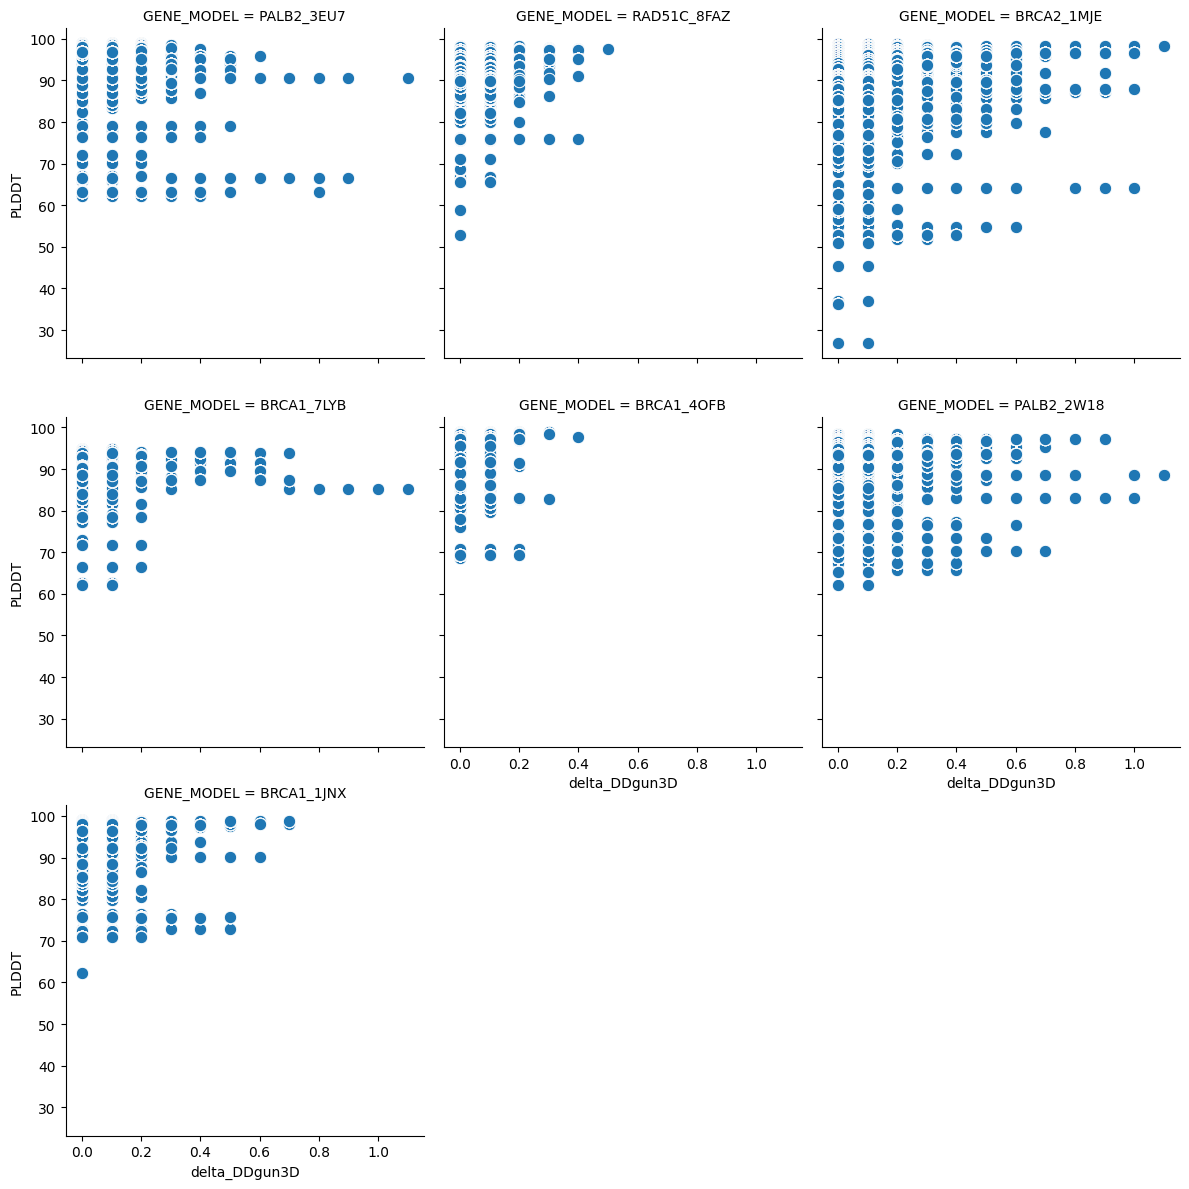

In [46]:
# Look into PLDDT
result_feature_PLDDT_df = result_feature_df[['PLDDT', 'mutations', 'GENE_MODEL', 'delta_FoldX',
                                           'delta_DDgun3D', 'delta_Rosetta']]
result_feature_PLDDT_df['delta_FoldX'] = result_feature_PLDDT_df['delta_FoldX'].abs()
result_feature_PLDDT_df['delta_DDgun3D'] = result_feature_PLDDT_df['delta_DDgun3D'].abs()
result_feature_PLDDT_df['delta_Rosetta'] = result_feature_PLDDT_df['delta_Rosetta'].abs()
result_feature_PLDDT_df

g = sns.FacetGrid(result_feature_PLDDT_df, col="GENE_MODEL",  col_wrap=3, height=4)
g.map_dataframe(sns.scatterplot, y='PLDDT', x='delta_DDgun3D', s=80)

In [47]:

result_feature_distance_df = result_feature_df[['Mean_Distance', 'mutations', 'GENE_MODEL', 
                                                'DDgun3D_AF2', 'FoldX_AF2', 'Rosetta_AF2',
                                               'DDgun3D_crystal', 'FoldX_crystal', 'Rosetta_crystal']]
result_feature_distance_df = result_feature_distance_df.dropna()
result_feature_distance_df = result_feature_distance_df.reset_index(drop=True)
#result_feature_distance_df[result_feature_distance_df['GENE_MODEL'] == "BRCA1_7LYB"]
result_feature_distance_df = result_feature_distance_df[result_feature_distance_df['GENE_MODEL'] != 'BRCA1_7LYB']
result_feature_distance_df.GENE_MODEL.value_counts()

BRCA2_1MJE     70374
RAD51C_8FAZ    36974
PALB2_2W18     34308
PALB2_3EU7     29970
BRCA1_4OFB     24379
BRCA1_1JNX     24134
Name: GENE_MODEL, dtype: int64

In [48]:
per_distance_df = pd.DataFrame(columns=['Predictor','MODEL GENE', 'DIST', 'PCC', 'P-Value', 
                                        'Lower Bound', 'Upper Bound', 'total', 'Error'])

distance_list = [0.5,1,1.5, 2,3,4]
model_list = list(set(result_feature_distance_df.GENE_MODEL.tolist()))
for model in model_list:
    print(model)
    for dist in distance_list:
        result_feature_distance_model_df = result_feature_distance_df[(result_feature_distance_df['GENE_MODEL'] == model) & (result_feature_distance_df['Mean_Distance'] <= dist)]
        r,p,lo,hi,n, err = pearsonr_ci(result_feature_distance_model_df['FoldX_AF2'], 
                                       result_feature_distance_model_df['FoldX_crystal'])
        per_distance_df = per_distance_df.append({"Predictor":'FoldX',
                                                  'MODEL GENE': model,
                                                   'DIST': dist,
                                                  'PCC': r,
                                                   'P-Value': p,
                                                  'Lower Bound': lo,
                                                  'Upper Bound': hi,
                                                  'total': n, 'Error': err},ignore_index=True)

for model in model_list:
    for dist in distance_list:
        result_feature_distance_model_df = result_feature_distance_df[(result_feature_distance_df['GENE_MODEL'] == model) & (result_feature_distance_df['Mean_Distance'] <= dist)]
        r,p,lo,hi,n,err = pearsonr_ci(result_feature_distance_model_df['DDgun3D_AF2'],
                                          result_feature_distance_model_df['DDgun3D_crystal'])
        per_distance_df = per_distance_df.append({"Predictor":'DDGun3D',
                                                  'MODEL GENE': model,
                                                   'DIST': dist,
                                                  'PCC': r,
                                                   'P-Value': p,
                                                  'Lower Bound': lo,
                                                  'Upper Bound': hi,
                                                  'total': n, 'Error': err},ignore_index=True)
        #print(model,dist, r,p,lo,hi,n )

for model in model_list:
    for dist in distance_list:
        result_feature_distance_model_df = result_feature_distance_df[(result_feature_distance_df['GENE_MODEL'] == model) & (result_feature_distance_df['Mean_Distance'] <= dist)]
        r,p,lo,hi,n,err = pearsonr_ci(result_feature_distance_model_df['Rosetta_AF2'], 
                                          result_feature_distance_model_df['Rosetta_crystal'])
        per_distance_df = per_distance_df.append({"Predictor":'Rosetta',
                                                  'MODEL GENE': model,
                                                   'DIST': dist,
                                                  'PCC': r,
                                                   'P-Value': p,
                                                  'Lower Bound': lo,
                                                  'Upper Bound': hi,
                                                  'total': n, 'Error': err},ignore_index=True)
        #print(model,dist, r,p,lo,hi,n )
    
    
#g = sns.FacetGrid(per_distance_df, col="MODEL GENE",  col_wrap=3, height=4)
list(set(result_feature_distance_df.GENE_MODEL.tolist()))

PALB2_2W18
BRCA1_1JNX
BRCA1_4OFB
RAD51C_8FAZ
PALB2_3EU7
BRCA2_1MJE


['PALB2_2W18',
 'BRCA1_1JNX',
 'BRCA1_4OFB',
 'RAD51C_8FAZ',
 'PALB2_3EU7',
 'BRCA2_1MJE']

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/seaborn/axisgrid.py:806: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)


<Figure size 1000x1600 with 0 Axes>

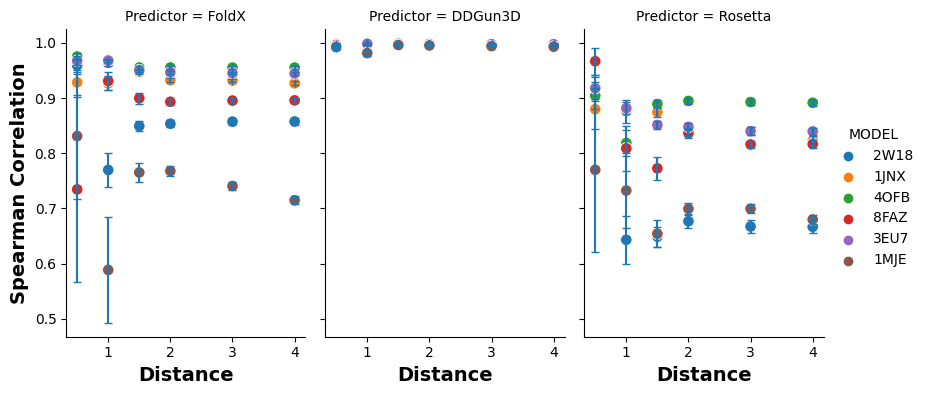

In [70]:
per_distance_df[['GENE', "MODEL"]] = per_distance_df['MODEL GENE'].str.split("_", expand=True)
plt.figure(figsize=(10, 16))
g = sns.FacetGrid(per_distance_df, col="Predictor",  col_wrap=3, height=4, aspect=.7)
g.map_dataframe(sns.scatterplot, y='PCC', x='DIST',  hue='MODEL',s=70)
g.map(plt.errorbar, "DIST", "PCC", "Error", marker="|", fmt='o',capsize=3)

g.set_ylabels('Spearman Correlation', fontsize=14, fontweight='bold')
g.set_xlabels('Distance', fontsize=14, fontweight='bold')
g.add_legend(title="MODEL")
plt.savefig('ddg_distance_correlation.png', dpi=300)
plt.show()
# Show the plot


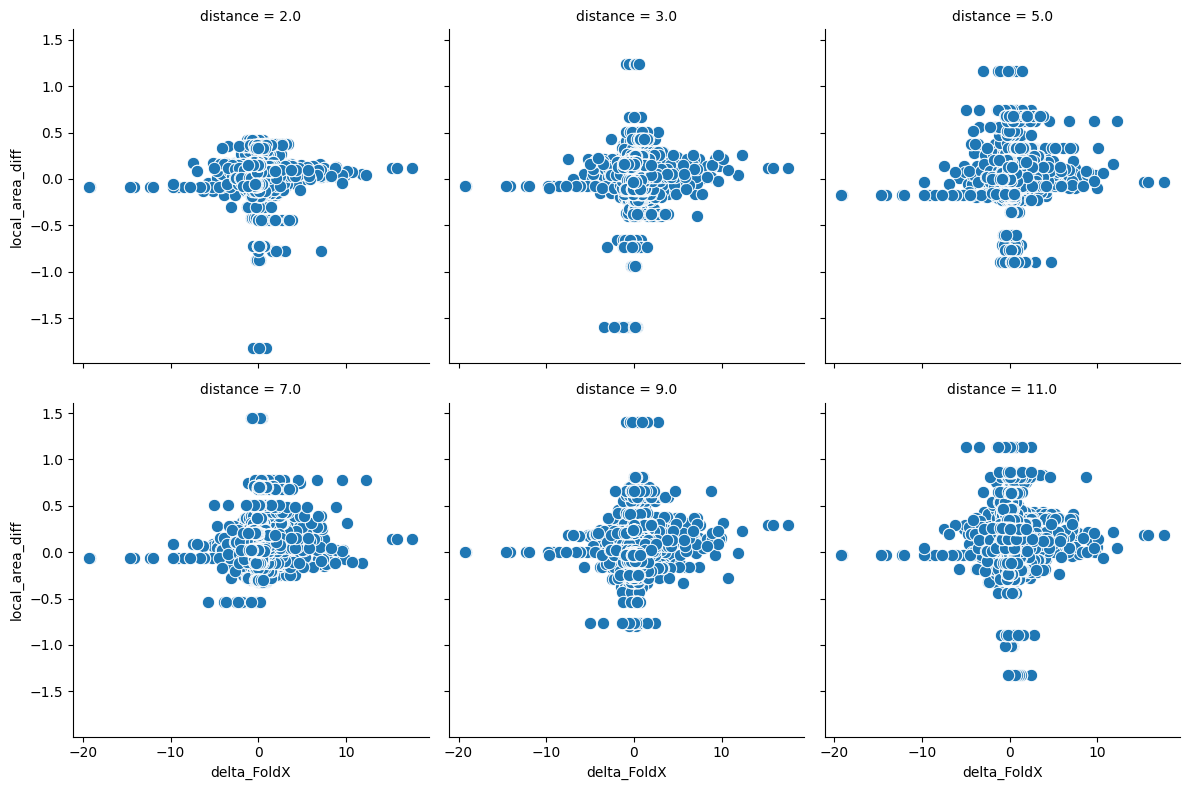

In [50]:
new_df = BRCA1_ddg_4OFB_results_feature_df[['mutations','local_area_diff','group', 'distance', 'delta_FoldX', 'delta_Rosetta', 'delta_DDgun3D']]
new_df = new_df.dropna()
new_df = new_df.drop_duplicates()
g = sns.FacetGrid(new_df, col="distance",  col_wrap=3, height=4)
g.map_dataframe(sns.scatterplot, y='local_area_diff', x='delta_FoldX', s=80)

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/seaborn/axisgrid.py:806: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/seaborn/axisgrid.py:806: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/seaborn/axisgrid.py:806: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args

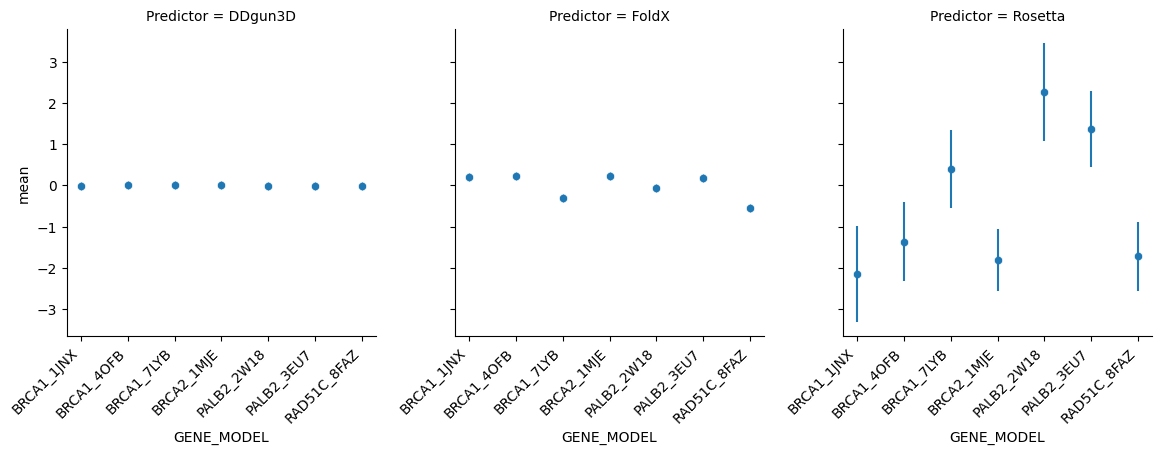

In [51]:
mut_delta_df = pivot_delta_df[['mutations', 'GENE_MODEL', 'delta_FoldX', 'delta_DDgun3D', 'delta_Rosetta']]
grouped_df = mut_delta_df.groupby('GENE_MODEL').agg(
    delta_FoldX_mean=('delta_FoldX', 'mean'),
    delta_FoldX_std=('delta_FoldX', 'std'),
    delta_FoldX_sem=('delta_FoldX', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    delta_FoldX_threshold=('delta_FoldX', lambda x: np.nanpercentile(x, 99)),
    delta_DDgun3D_mean=('delta_DDgun3D', 'mean'),
    delta_DDgun3D_std=('delta_DDgun3D', 'std'),
    delta_DDgun3D_sem=('delta_DDgun3D', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    delta_DDgun3D_threshold=('delta_DDgun3D', lambda x: np.nanpercentile(x, 99)),
    delta_Rosetta_mean=('delta_Rosetta', 'mean'),
    delta_Rosetta_std=('delta_Rosetta', 'std'),
    delta_Rosetta_sem=('delta_Rosetta', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
    delta_Rosetta_threshold=('delta_Rosetta', lambda x: np.nanpercentile(x, 99))
)
grouped_df = grouped_df.reset_index()
grouped_plot_df = grouped_df[['GENE_MODEL', 'delta_FoldX_mean', 'delta_FoldX_sem',
                              'delta_DDgun3D_mean', 'delta_DDgun3D_sem', 'delta_Rosetta_mean', 'delta_Rosetta_sem']]
# Split the 'Variable' column into three separate columns
grouped_plot_melt_df = pd.melt(grouped_plot_df, id_vars=['GENE_MODEL'], var_name='Variable', value_name='Value')
grouped_plot_melt_df[['Delta', 'Predictor', 'metric']] = grouped_plot_melt_df['Variable'].str.split('_', expand=True)

# Drop the original 'Variable' column
#grouped_plot_melt_df.drop(columns=['Variable'], inplace=True)

# Display the DataFrame
grouped_plot_melt_df = grouped_plot_melt_df.drop(['Variable', 'Delta'], axis=1)

grouped_plot_melt_pdf = grouped_plot_melt_df.pivot_table(index=['GENE_MODEL', 'Predictor'], 
                                                         columns=['metric'], values='Value',
                                                         aggfunc='first')

grouped_plot_melt_pdf = grouped_plot_melt_pdf.reset_index()
grouped_plot_melt_pdf
#grouped_plot_melt_df

# Create the FacetGrid
g = sns.FacetGrid(grouped_plot_melt_pdf, col='Predictor', col_wrap=3, height=4, sharey=True)

# Map scatterplot onto the grid
g.map_dataframe(sns.scatterplot, x='GENE_MODEL', y='mean')
g.map(plt.errorbar, "GENE_MODEL", "mean", "sem", marker="|", fmt='o')
# Rotate x-axis labels for better readability
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show the plot
plt.show()


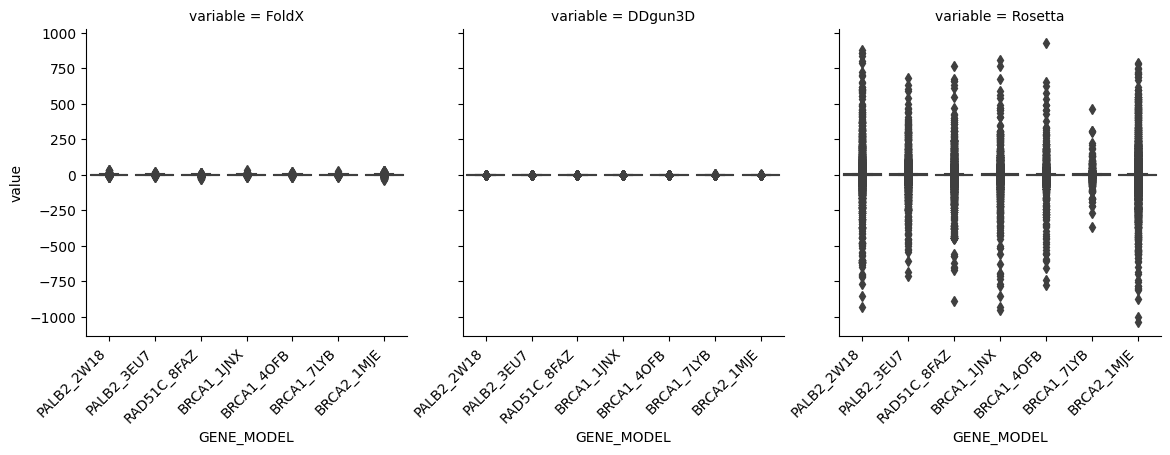

In [52]:
mut_delta_melt_df = pd.melt(mut_delta_df, id_vars=['mutations', 'GENE_MODEL'])
mut_delta_melt_df['variable'] =  mut_delta_melt_df['variable'].str.replace("delta_", "")


g = sns.FacetGrid(mut_delta_melt_df, col='variable', col_wrap=3, height=4, sharey=True)

# Map scatterplot onto the grid
g.map_dataframe(sns.boxplot, x='GENE_MODEL', y='value')
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

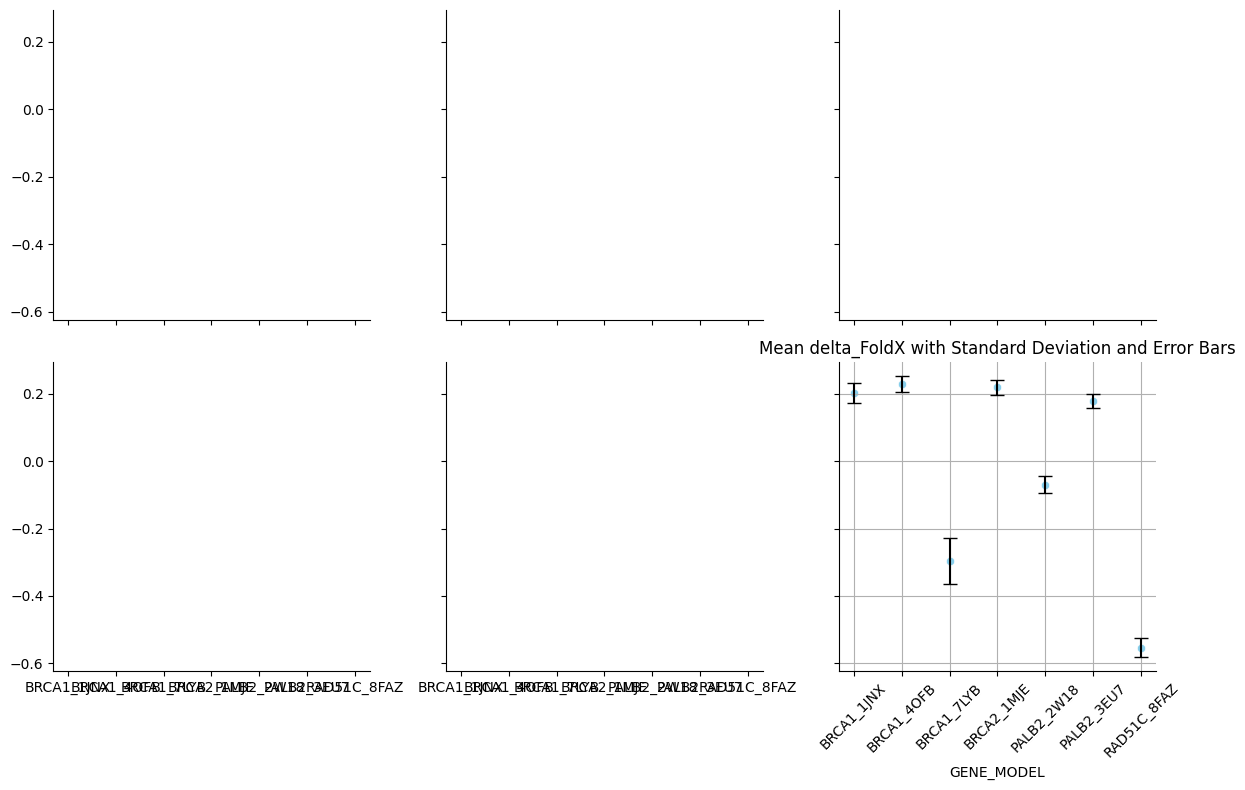

,GENE_MODEL,delta_FoldX_mean,delta_FoldX_std,delta_FoldX_sem,delta_FoldX_threshold,delta_DDgun3D_mean,delta_DDgun3D_std,delta_DDgun3D_sem,delta_DDgun3D_threshold,delta_Rosetta_mean,delta_Rosetta_std,delta_Rosetta_sem,delta_Rosetta_threshold
0,BRCA1_1JNX,0.202290,1.842385,0.028637,6.712105,-0.007321,0.098819,0.001536,0.2,-2.156770,75.453685,1.172824,238.817888
1,BRCA1_4OFB,0.228725,1.571736,0.024313,5.822530,0.006054,0.058661,0.000907,0.2,-1.364482,62.783511,0.971202,178.896786
2,BRCA1_7LYB,-0.296890,2.559308,0.067703,4.463274,0.004829,0.163849,0.004334,0.7,0.396775,36.027779,0.953062,117.477576
3,BRCA2_1MJE,0.218659,2.545101,0.023381,7.882592,0.015596,0.126020,0.001158,0.5,-1.817065,82.553173,0.758391,299.566309
4,PALB2_2W18,-0.070082,1.929702,0.025269,4.825495,-0.020027,0.127170,0.001665,0.3,2.272250,91.461096,1.197644,345.354340
5,PALB2_3EU7,0.178583,1.409606,0.019846,4.823129,-0.004797,0.109740,0.001545,0.3,1.367382,66.044895,0.929841,255.302528
6,RAD51C_8FAZ,-0.553150,2.253231,0.028435,3.021632,-0.015687,0.073424,0.000927,0.1,-1.724288,67.108703,0.846903,223.403058


In [62]:
plt.figure(figsize=(10, 6))
g = sns.FacetGrid(new_df, col="distance",  col_wrap=3, height=4)
sns.scatterplot(data=grouped_df, x='GENE_MODEL', y='delta_FoldX_mean', color='skyblue')
plt.errorbar(x=grouped_df.index, y=grouped_df['delta_FoldX_mean'], yerr=grouped_df['delta_FoldX_sem'], fmt='none', ecolor='black', capsize=5)
plt.xlabel('GENE_MODEL')
plt.ylabel('delta_FoldX_mean')
plt.title('Mean delta_FoldX with Standard Deviation and Error Bars')
plt.xticks(rotation=45)
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
grouped_df

In [54]:

mut_delta_foldx_df = mut_delta_df[(mut_delta_df['delta_FoldX'] > 2) | (mut_delta_df['delta_FoldX'] < -2)]
mut_delta_foldx_df = mut_delta_foldx_df[['mutations', 'GENE_MODEL', 'delta_FoldX']]

def extract_integers(s):
    return [int(match.group()) for match in re.finditer(r'\d+', s)]

def filter_and_count_alt(check_df, column, cutoff):
    aro_list = ['W', 'Y', "H", "F"]
    check_df = check_df[['mutations', column]]
    check_df['REF'] = check_df['mutations'].str[0]
    check_df['POS'] = check_df['mutations'].apply(lambda x: extract_integers(x)[0])
    check_df['ALT'] = check_df['mutations'].str[-1]
    check_df = check_df.sort_values(by='POS')
    check_filter_df = check_df[(check_df[column] > cutoff) | (check_df[column] < -cutoff)]
    alt_counts = pd.DataFrame(check_filter_df['ALT'].value_counts())
    alt_counts = alt_counts.reset_index()
    alt_counts.columns = ['AminoAcid', 'Counts']
    alt_counts['Group'] = alt_counts['AminoAcid'].apply(lambda x: 1 if x in aro_list else 0)
    group_0_counts = alt_counts[alt_counts['Group'] == 0]['Counts']
    total_non_aro_count = sum(group_0_counts)
    group_1_counts = alt_counts[alt_counts['Group'] == 1]['Counts']
    total_aro_count = sum(group_1_counts)
    t_statistic, p_value = ttest_ind(group_0_counts, group_1_counts)
    return total_non_aro_count, total_aro_count, p_value
    


In [55]:
grouped_threshold_df = grouped_df[['GENE_MODEL', 'delta_FoldX_threshold', 'delta_DDgun3D_threshold', 'delta_Rosetta_threshold']]
for model in grouped_threshold_df.GENE_MODEL.tolist():
    foldx_threshold = grouped_threshold_df[grouped_threshold_df['GENE_MODEL'] == model]['delta_FoldX_threshold'].values[0]
    total_non_aro_count, total_aro_count, p = filter_and_count_alt(mut_delta_df, 'delta_FoldX', foldx_threshold)
    print(model, total_non_aro_count, total_aro_count, p)

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


BRCA1_1JNX 272 520 6.401068953484498e-08
BRCA1_4OFB 360 646 8.551977755911372e-08
BRCA1_7LYB 627 892 3.550489847768735e-08
BRCA2_1MJE 170 397 1.6278799350786416e-07
PALB2_2W18 549 816 4.7957633277640476e-08
PALB2_3EU7 550 816 4.819166861402073e-08
RAD51C_8FAZ 1377 1346 4.0777840716706333e-07


In [56]:
mut_delta_df

,mutations,GENE_MODEL,delta_FoldX,delta_DDgun3D,delta_Rosetta
0,A1017A,PALB2_2W18,0.000000e+00,0.0,-1.314746e-12
1,A1017A,PALB2_3EU7,3.183234e-13,0.0,0.000000e+00
2,A1017C,PALB2_2W18,-1.536405e-01,0.0,-3.313905e+01
3,A1017C,PALB2_3EU7,-4.743373e-01,-0.1,3.048024e-02
4,A1017D,PALB2_2W18,2.347120e+00,0.1,-1.231547e+01
...,...,...,...,...,...
42458,Y929V,PALB2_3EU7,-2.160400e-02,0.0,4.471397e-01
42459,Y929W,PALB2_2W18,6.963840e-02,0.0,-6.155721e-02
42460,Y929W,PALB2_3EU7,-1.003065e+00,0.0,-3.061053e+00
42461,Y929Y,PALB2_2W18,6.998174e-05,0.0,0.000000e+00
